In [1]:
import PIL
from PIL import __version__
PIL.PILLOW_VERSION = __version__

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

import copy
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters for MNIST
inputSize = 784
hiddenLayerSize = 100
numberClasses = 10
numberEpochs = 2
batchSize = 24
learningRate = 0.001

#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5, ))])

# Load MNIST dataset
trainDataset = torchvision.datasets.MNIST('./data', train = True, transform = transforms.ToTensor(), download = True)
testDataset = torchvision.datasets.MNIST('./data', train = False, transform = transforms.ToTensor())

In [2]:
trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=False)
testLoader = torch.utils.data.DataLoader(dataset = testDataset, batch_size=24, shuffle=False)

In [2037]:
# MODEL _ 2 _ 1
# Unipolar
# bitwidth = 4
# Voting Mechansim = Off

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, stochasticPrecision):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:          
            for k in range(stochasticPrecision):
                referenceWeights_1 = torch.rand(self.hiddenLayersSize, self.inputSize)
                referenceWeights_2 = torch.rand(self.numberClasses, self.hiddenLayersSize)
                referenceBias_1 = torch.rand(self.hiddenLayersSize)
                referenceBias_2 = torch.rand(self.numberClasses)
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = torch.div(count_1, stochasticPrecision)
            self.linear_2.weight.data = torch.div(count_2, stochasticPrecision)
            self.linear_1.bias.data = torch.div(count_3, stochasticPrecision)
            self.linear_2.bias.data = torch.div(count_4, stochasticPrecision)
        
        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = 0.0
        output = self.linear_2(output)
        return output
    
model_2_1 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_1_losses = []
model_2_1_acc = []

In [2043]:
# loss
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_1.parameters(), lr = 7e-8)

# training loop
n_total_steps = len(trainLoader)

numberOfVoting = 4

for epoch in range(150):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        samples = torch.div(dataCount, numberOfVoting)
                
        images = samples.reshape(-1, 784)
                
        # forward
        outputs = model_2_1(images, 0, 0, 4)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if i == 0:
            #break
        
        if loss.item() < 0.002:
            print(f'{loss.item():.4f}')
        
        if (i+1) % 2500 == 0:
            model_2_1_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{150}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            dataCount = torch.zeros(24, 1, 28, 28)

            for k in range(numberOfVoting):
                referenceTrainData = torch.rand(24, 1, 28, 28)/20
                dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)

            samples = torch.div(dataCount, numberOfVoting)

            images = samples.reshape(-1, 784)

            outputs = model_2_1(images, 0, 1, 4)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')

        model_2_1_acc.append(accuracy)

epoch 1/150, step 2500 / 2500, loss = 0.43648
accuracy = 87.3798076923077
epoch 2/150, step 2500 / 2500, loss = 0.44276
accuracy = 87.43990384615384
epoch 3/150, step 2500 / 2500, loss = 0.44099
accuracy = 86.82892628205128
epoch 4/150, step 2500 / 2500, loss = 0.44147
accuracy = 87.03926282051282
epoch 5/150, step 2500 / 2500, loss = 0.44106
accuracy = 87.5400641025641
epoch 6/150, step 2500 / 2500, loss = 0.44460
accuracy = 87.44991987179488
epoch 7/150, step 2500 / 2500, loss = 0.44299
accuracy = 87.28966346153847
epoch 8/150, step 2500 / 2500, loss = 0.43857
accuracy = 87.5801282051282
epoch 9/150, step 2500 / 2500, loss = 0.44474
accuracy = 87.55008012820512
epoch 10/150, step 2500 / 2500, loss = 0.43970
accuracy = 86.94911858974359
epoch 11/150, step 2500 / 2500, loss = 0.44102
accuracy = 87.109375
epoch 12/150, step 2500 / 2500, loss = 0.43869
accuracy = 87.46995192307692
epoch 13/150, step 2500 / 2500, loss = 0.44044
accuracy = 87.5801282051282
epoch 14/150, step 2500 / 2500, l

In [1842]:
# testing
testModel = copy.deepcopy(model_2_1)
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader):  
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float() 
        
        images = samples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 4, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 86.88902243589743


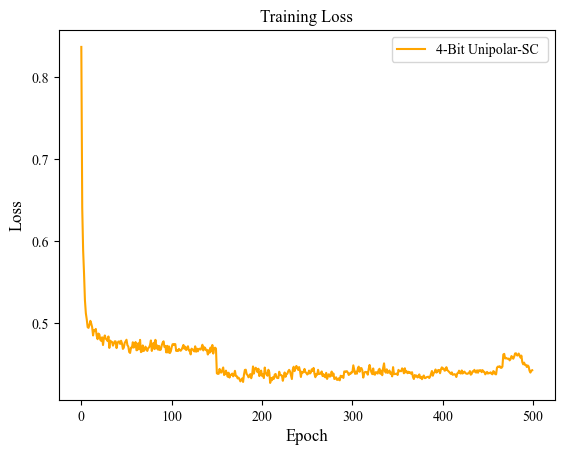

In [2487]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_1_losses, color = 'orange', label = '4-Bit Unipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('4b_1v_U_loss.png') 
plt.show()

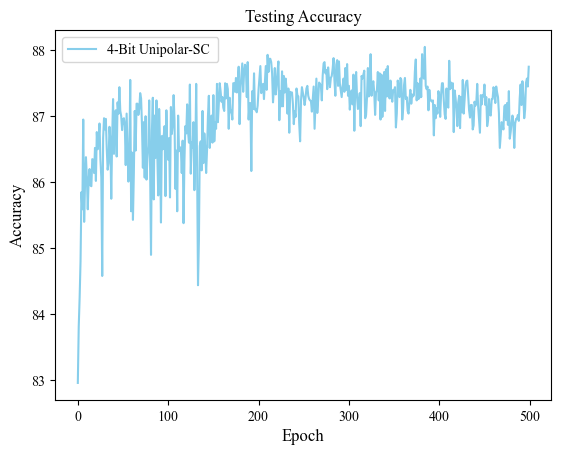

In [2488]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_1_acc, color = 'skyblue', label = '4-Bit Unipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('4b_1v_U_acc.png')  
plt.show()

In [2053]:
# MODEL _ 2 _ 2
# Biipolar
# bitwidth = 4
# Voting Mechansim = Off

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, stochasticPrecision, divide_1, divide_2, divide_3, divide_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:          
            for k in range(stochasticPrecision):
                #referenceWeights_1 = (torch.randn(self.hiddenLayersSize, self.inputSize)/divide_1)
                #referenceWeights_2 = (torch.randn(self.numberClasses, self.hiddenLayersSize)/divide_2)
                #referenceBias_1 = (torch.randn(self.hiddenLayersSize)/divide_3)
                #referenceBias_2 = (torch.randn(self.numberClasses)/divide_4)
                #referenceWeights_1 = random.uniform(0.1 * self.linear_1.weight.data.min(), 1.1 * self.linear_1.weight.data.max())
                #referenceWeights_2 = random.uniform(0.1 * self.linear_2.weight.data.min(), 1.1 * self.linear_2.weight.data.max())
                #referenceBias_1 = random.uniform(0.1 * self.linear_1.bias.data.min(), 1.1 * self.linear_1.bias.data.max())
                #referenceBias_2 = random.uniform(0.1 * self.linear_2.bias.data.min(), 1.1 * self.linear_2.bias.data.max())
                referenceWeights_1 = (2 * torch.rand(self.hiddenLayersSize, self.inputSize)/divide_1) - 1
                referenceWeights_2 = (2 * torch.rand(self.numberClasses, self.hiddenLayersSize)/divide_2)- 1
                referenceBias_1 = (2 * torch.rand(self.hiddenLayersSize)/divide_3) - 1
                referenceBias_2 = (2 * torch.rand(self.numberClasses)/divide_4) - 1
                
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = (2 * torch.div(count_1, stochasticPrecision)) - 1
            self.linear_2.weight.data = (2 * torch.div(count_2, stochasticPrecision)) - 1
            self.linear_1.bias.data = (2 * torch.div(count_3, stochasticPrecision)) - 1
            self.linear_2.bias.data = (2 * torch.div(count_4, stochasticPrecision)) - 1
        
        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = -1.0
        output = self.linear_2(output)
        return output
    
model_2_2 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_2_losses = []
model_2_2_acc = []

In [2060]:
# loss
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_2.parameters(), lr = 7e-8)

# training loop
n_total_steps = len(trainLoader)

numberOfVoting = 4

for epoch in range(100):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random number                
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        samples = 2 * torch.div(dataCount, numberOfVoting) - 1
            
        images = samples.reshape(-1, 784)
                
        # forward
        outputs = model_2_2(images, 0, 0, 4, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if i == 0:
            #break
        
        if loss.item() < 0.002:
            print(f'{loss.item():.4f}')
        
        if (i+1) % 2500 == 0:
            model_2_2_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{100}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
                
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            dataCount = torch.zeros(24, 1, 28, 28)

            for k in range(numberOfVoting):
                referenceTrainData = torch.rand(24, 1, 28, 28)/20
                dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)

            samples = 2 * torch.div(dataCount, numberOfVoting) - 1

            images = samples.reshape(-1, 784)

            outputs = model_2_2(images, 0, 1, 4, 1, 1, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_2_acc.append(accuracy)

epoch 1/100, step 2500 / 2500, loss = 0.3111
accuracy = 90.22435897435898
epoch 2/100, step 2500 / 2500, loss = 0.3102
accuracy = 90.25440705128206
epoch 3/100, step 2500 / 2500, loss = 0.3096
accuracy = 90.68509615384616
epoch 4/100, step 2500 / 2500, loss = 0.3104
accuracy = 90.05408653846153
epoch 5/100, step 2500 / 2500, loss = 0.3147
accuracy = 90.10416666666667
epoch 6/100, step 2500 / 2500, loss = 0.3124
accuracy = 90.61498397435898
epoch 7/100, step 2500 / 2500, loss = 0.3124
accuracy = 90.1542467948718
epoch 8/100, step 2500 / 2500, loss = 0.3116
accuracy = 90.71514423076923
epoch 9/100, step 2500 / 2500, loss = 0.3135
accuracy = 90.625
epoch 10/100, step 2500 / 2500, loss = 0.3094
accuracy = 90.46474358974359
epoch 11/100, step 2500 / 2500, loss = 0.3126
accuracy = 90.22435897435898
epoch 12/100, step 2500 / 2500, loss = 0.3136
accuracy = 90.44471153846153
epoch 13/100, step 2500 / 2500, loss = 0.3139
accuracy = 90.46474358974359
epoch 14/100, step 2500 / 2500, loss = 0.3161


In [1903]:
# testing
testModel = copy.deepcopy(model_2_2)
numberOfVoting = 4
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader):  
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        samples = 2 * torch.div(dataCount, numberOfVoting) - 1
        
        images = samples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 4, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 79.6474358974359


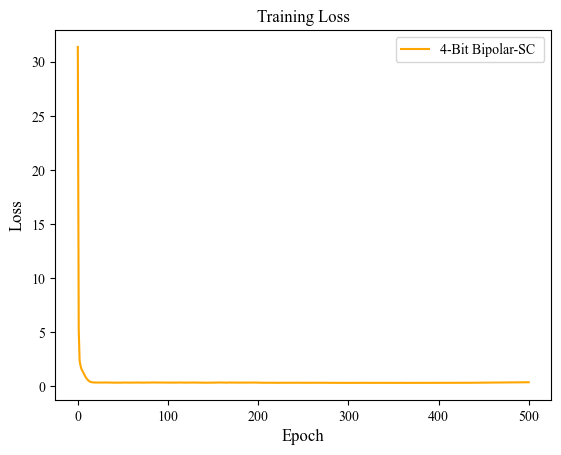

In [2489]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_2_losses, color = 'orange', label = '4-Bit Bipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})
plt.savefig('4b_1v_B_loss.png') 
plt.show()

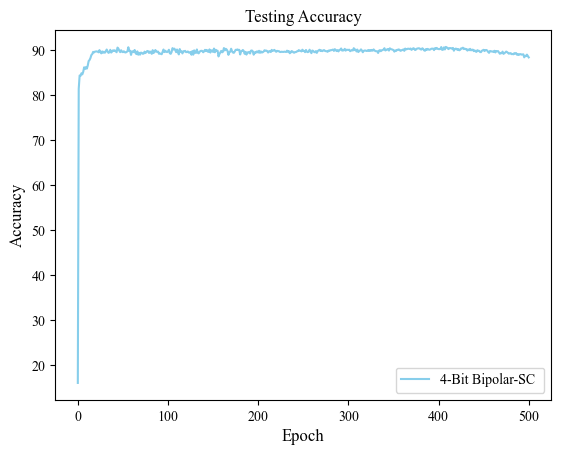

In [2490]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_2_acc, color = 'skyblue', label = '4-Bit Bipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('4b_1v_B_acc.png')  
plt.show()

In [54]:
save_path = 'C:\data'
torch.save(model_2_2, 'C:\data\Saved Models\model_2_2.pth')

In [78]:
loaded_Model = torch.load('C:\data\Saved Models\model_2_2.pth')

In [79]:
# loss
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(loaded_Model.parameters(), lr = 5e-4)

# training loop
n_total_steps = len(trainLoader)

for epoch in range(3):
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 28, 28)
        
        for j in range(len(images)):
            for k in range(28):
                for z in range(28):
                    if images[j][0][k][z] >= referenceTrainData[j][k][z]:
                        images[j][0][k][z] = 1
                    else:
                        images[j][0][k][z] = 0         
                
        images = images.reshape(-1, 784)
                
        # forward
        outputs = loaded_Model(images, 0, 0, 4, 2)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.1:
            print(f'{loss.item():.4f}')
            break
        
        if (i+1) % 100 == 0:
            print(loaded_Model.linear_1.weight.data[0])
            print('-------------------------------')
        
        if (i+1) % 25 == 0:
            print(f'epoch {epoch+1}/{3}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')

epoch 1/3, step 25 / 2500, loss = 0.6052
epoch 1/3, step 50 / 2500, loss = 0.8060
epoch 1/3, step 75 / 2500, loss = 0.5301
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.3850e-04,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00, -1.3711e-07,
         3.8815e-07,  5.2733e-06, -3.8422e-06, -1.0973e-04, -3.9199e-06,
         0.0000e+00,  0.0000e+00,  7.1099e-06, -2.4699e-06, -2.8502e-07,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,
 

KeyboardInterrupt: 

In [2454]:
# MODEL _ 2 _ 3
# Unipolar
# bitwidth = 1
# Voting Mechansim = 4

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, threshhold):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:         
            #with torch.no_grad():               
            for k in range(numberOfVoting):
                referenceWeights_1 = torch.rand(self.hiddenLayersSize, self.inputSize)
                referenceWeights_2 = torch.rand(self.numberClasses, self.hiddenLayersSize)
                referenceBias_1 = torch.rand(self.hiddenLayersSize)
                referenceBias_2 = torch.rand(self.numberClasses)
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = torch.ge(count_1, threshhold).float()
            self.linear_2.weight.data = torch.ge(count_2, threshhold).float()
            self.linear_1.bias.data = torch.ge(count_3, threshhold).float()
            self.linear_2.bias.data = torch.ge(count_4, threshhold).float()

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            output = torch.ge(output, randomVariables).float()
        output = self.linear_2(output)
        return output
    
model_2_3 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_3_losses = []
model_2_3_acc = []

In [2455]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_3.parameters(), lr = 7e-4)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(10):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_3(samples, 0, skipFlag, 4, 2)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.0003:
            print(f'{loss.item():.4f}')
            torch.save(model_2_3, 'C:/data/Saved_Models/best_model.pth')
            
        if loss.item() < 0.01:
            print(f'{loss.item():.4f}')
            torch.save(model_2_3, 'C:/data/Saved_Models/best_model_1.pth')
        
        if (i+1) % 2500 == 0:
            model_2_3_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{10}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            dataCount = torch.zeros(24, 1, 28, 28)

            for k in range(numberOfVoting):
                referenceTrainData = torch.rand(24, 1, 28, 28)/20
                dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)

            samples = torch.div(dataCount, numberOfVoting)

            images = samples.reshape(-1, 784)

            outputs = model_2_3(images, 0, 1, 4, 2)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_3_acc.append(accuracy)

epoch 1/10, step 2500 / 2500, loss = 2.3385
accuracy = 42.658253205128204
epoch 2/10, step 2500 / 2500, loss = 2.2427
accuracy = 41.43629807692308
epoch 3/10, step 2500 / 2500, loss = 2.1742
accuracy = 42.057291666666664
epoch 4/10, step 2500 / 2500, loss = 2.0796
accuracy = 43.30929487179487
epoch 5/10, step 2500 / 2500, loss = 1.9157
accuracy = 44.33092948717949
epoch 6/10, step 2500 / 2500, loss = 1.8631
accuracy = 45.94350961538461
epoch 7/10, step 2500 / 2500, loss = 1.8262
accuracy = 47.56610576923077
epoch 8/10, step 2500 / 2500, loss = 1.7578
accuracy = 48.16706730769231
epoch 9/10, step 2500 / 2500, loss = 1.7411
accuracy = 46.584535256410255
epoch 10/10, step 2500 / 2500, loss = 1.6916
accuracy = 46.1338141025641


In [2029]:
model_2_3_losses_temp = model_2_3_losses

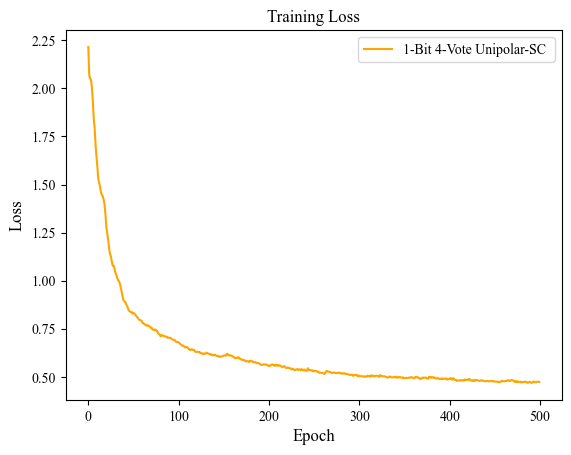

In [2030]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_3_losses, color = 'orange', label = '1-Bit 4-Vote Unipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.show()

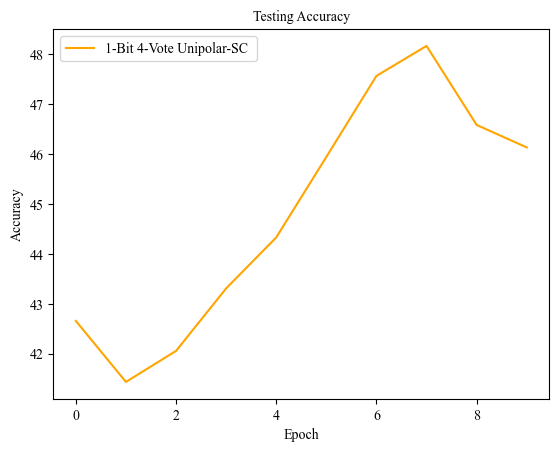

In [2617]:
font = {'family': 'Times New Roman',
        'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_3_acc, color = 'orange', label = '1-Bit 4-Vote Unipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.show()

In [2031]:
# testing
testModel = copy.deepcopy(model_2_3)
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader): 
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/10
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = torch.ge(images, referenceTrainData).float()
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 4, 2)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 85.71714743589743


In [1507]:
examples = iter(testLoader)
samples, labels = next(examples)
testSamples = torch.zeros_like(samples)

In [1511]:
# testing

testModel = copy.deepcopy(model_2_3)

numberVoting = 1

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for count in range(numberVoting):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/10
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = torch.gt(samples, referenceTrainData).float()
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 4, 2)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        print(predictions)
        print(labels)
        print('-------------')
        
        print(100.0 * (numberCorrect) / numberSamples)
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

tensor([0, 7, 9, 6, 7, 5, 7, 8, 3, 4, 5, 1, 2, 1, 8, 1, 3, 5, 0, 1, 6, 7, 9, 2])
tensor([0, 7, 9, 6, 7, 5, 7, 8, 3, 4, 5, 1, 2, 1, 8, 1, 3, 9, 0, 1, 6, 7, 9, 2])
-------------
95.83333333333333
accuracy = 95.83333333333333


In [855]:
# testing

testModel = copy.deepcopy(model_2_3)

batchSize = 24

numberOfImages = batchSize

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    numberVoting = 8
    stochasticPrecision = 1
    collection = torch.zeros(batchSize, numberVoting)
    for count in range(numberVoting):
        
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = torch.gt(samples, referenceTrainData).float()
        
        referenceWeights_1 = torch.rand(100, 784)
        referenceWeights_2 = torch.rand(10, 100)
        referenceBias_1 = torch.rand(100)
        referenceBias_2 = torch.rand(10)
        
        testModel.linear_1.weight.data = torch.ge(model_2_3.linear_1.weight.data, referenceWeights_1).float()
        testModel.linear_2.weight.data = torch.ge(model_2_3.linear_2.weight.data, referenceWeights_2).float()
        testModel.linear_1.bias.data = torch.ge(model_2_3.linear_1.bias.data, referenceBias_1).float()
        testModel.linear_2.bias.data = torch.ge(model_2_3.linear_2.bias.data, referenceBias_2).float()
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 8, 8, 1, 1, 1, 1)
        
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        for counter in range(batchSize):
            collection[counter][count] = predictions[counter]
        
        print(predictions)
        print(labels)
        print('-------------')
        #print(numberSamples)
    
    results = torch.zeros(batchSize)
    for i in range(batchSize):
        unique_elements, counts = torch.unique(collection[i], return_counts=True)
        max_count_index = torch.argmax(counts)

        element_with_max_count = unique_elements[max_count_index]
        max_count = counts[max_count_index]

        results[i] = element_with_max_count.item()
        
    accuracy = 0
    for i in range(batchSize):
        accuracy += (results[i] == labels[i]).sum().item()
    print(results.int())
    print(labels)
    print('---------')
    print((accuracy/batchSize)*100)

tensor([1, 1, 0, 6, 5, 9, 2, 8, 4, 3, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
tensor([1, 1, 0, 6, 5, 9, 2, 3, 9, 8, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
-------------
tensor([1, 1, 0, 6, 5, 9, 2, 8, 4, 3, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
tensor([1, 1, 0, 6, 5, 9, 2, 3, 9, 8, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
-------------
tensor([1, 1, 0, 6, 5, 9, 2, 8, 4, 3, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
tensor([1, 1, 0, 6, 5, 9, 2, 3, 9, 8, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
-------------
tensor([1, 1, 0, 6, 5, 9, 2, 8, 4, 3, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
tensor([1, 1, 0, 6, 5, 9, 2, 3, 9, 8, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
-------------
tensor([1, 1, 0, 6, 5, 9, 2, 8, 4, 3, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
tensor([1, 1, 0, 6, 5, 9, 2, 3, 9, 8, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
-------------
tensor([1, 1, 0, 6, 5, 9, 2, 8, 4, 3, 7, 2, 5, 2, 0, 0, 9, 2, 6, 9, 0, 6, 3, 1])
tensor([1, 1, 0, 6, 5, 9, 2, 3, 9, 8, 7

In [2352]:
# MODEL _ 2 _ 4
# Unipolar
# bitwidth = 8
# Voting Mechansim = Off

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, threshhold, divide_1, divide_2, divide_3, divide_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = torch.rand(self.hiddenLayersSize, self.inputSize)/divide_1
                referenceWeights_2 = torch.rand(self.numberClasses, self.hiddenLayersSize)/divide_2
                referenceBias_1 = torch.rand(self.hiddenLayersSize)/divide_3
                referenceBias_2 = torch.rand(self.numberClasses)/divide_4
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = torch.div(count_1, numberOfVoting)
            self.linear_2.weight.data = torch.div(count_2, numberOfVoting)
            self.linear_1.bias.data = torch.div(count_3, numberOfVoting)
            self.linear_2.bias.data = torch.div(count_4, numberOfVoting)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = 0.0
        output = self.linear_2(output)
        return output
    
model_2_4 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_4_losses = []
model_2_4_acc = []

In [2526]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_4.parameters(), lr =  7e-8)

# training loop
n_total_steps = len(trainLoader)

flag = 0

numberOfVoting = 8

for epoch in range(300):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.ge(images, referenceTrainData).float(), dataCount)
        
        samples = torch.div(dataCount, numberOfVoting)
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_4(samples, 0, 0, 8, 4, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if loss.item() < 0.0003:
            print(f'{loss.item():.4f}')
        
        if (i+1) % 2500 == 0:
            model_2_4_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{300}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
        
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            dataCount = torch.zeros(24, 1, 28, 28)

            for k in range(numberOfVoting):
                referenceTrainData = torch.rand(24, 1, 28, 28)/20
                dataCount = torch.add( torch.ge(images, referenceTrainData).float(), dataCount)

            samples = torch.div(dataCount, numberOfVoting)

            images = samples.reshape(-1, 784)

            outputs = model_2_4(images, 0, 1, 8, 4, 1, 1, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_4_acc.append(accuracy)

epoch 1/300, step 2500 / 2500, loss = 0.4255
accuracy = 87.23958333333333
epoch 2/300, step 2500 / 2500, loss = 0.4278
accuracy = 87.6201923076923
epoch 3/300, step 2500 / 2500, loss = 0.4290
accuracy = 87.34975961538461
epoch 4/300, step 2500 / 2500, loss = 0.4258
accuracy = 87.4198717948718
epoch 5/300, step 2500 / 2500, loss = 0.4259
accuracy = 86.89903846153847
epoch 6/300, step 2500 / 2500, loss = 0.4302
accuracy = 87.03926282051282
epoch 7/300, step 2500 / 2500, loss = 0.4288
accuracy = 87.11939102564102
epoch 8/300, step 2500 / 2500, loss = 0.4277
accuracy = 87.48998397435898
epoch 9/300, step 2500 / 2500, loss = 0.4252
accuracy = 87.33974358974359
epoch 10/300, step 2500 / 2500, loss = 0.4275
accuracy = 86.86899038461539
epoch 11/300, step 2500 / 2500, loss = 0.4315
accuracy = 87.4599358974359
epoch 12/300, step 2500 / 2500, loss = 0.4295
accuracy = 87.28966346153847
epoch 13/300, step 2500 / 2500, loss = 0.4335
accuracy = 87.15945512820512
epoch 14/300, step 2500 / 2500, loss 

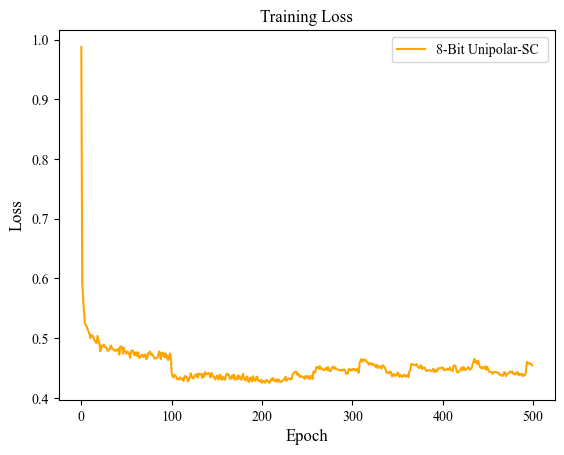

In [2527]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_4_losses, color = 'orange', label = '8-Bit Unipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})
plt.savefig('8b_1v_U_loss.png') 
plt.show()

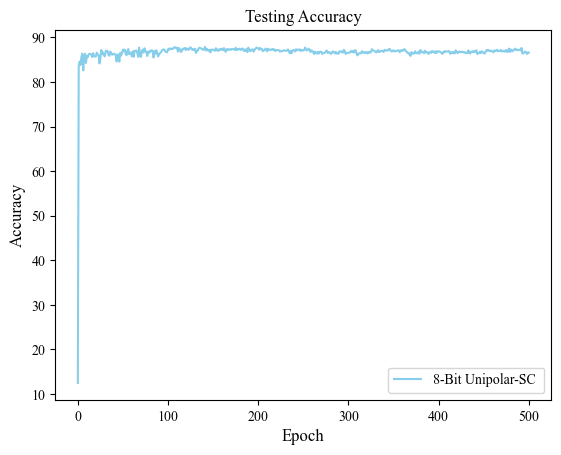

In [2528]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_4_acc, color = 'skyblue', label = '8-Bit Unipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('8b_1v_U_acc.png')  
plt.show()

In [2276]:
model_2_4.linear_1.weight.data[0]

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -8.7460e-28, -7.9934e-28,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -1.0350e-25,  7.9986e-30, -4.2255e-12, -2.2240e-12, -1.6202e-11,
        -2.2174e-10,  2.5057e-10,  5.5878e-08, -2.3376e-11, -4.9744e-09,
         1.0000e+00,  1.5499e-11,  1.5188e-11, -9.5131e-17, -4.9271e-10,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  3.0464e-20, -2.3908e-27,  1.0000e+00, -1.4353e-09,
        -6.6575e-09,  1.0000e+00,  1.0000e+00,  1.0

In [1628]:
# testing
testLoader = torch.utils.data.DataLoader(dataset = testDataset, batch_size=24, shuffle=True)

testModel = copy.deepcopy(model_2_4)
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader):    
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/50
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.gt(images, referenceTrainData).float()
        
        samples = samples.reshape(-1, 784)
        
        outputs = testModel(samples, 0, 1, 8, 2, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        #print(100.0 * (numberCorrect) / numberSamples)
        
        if i >= 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 85.35657051282051


In [1689]:
examples = iter(testLoader)
samples, labels = next(examples)
testSamples = torch.zeros_like(samples)

In [1104]:
# testing

testModel = copy.deepcopy(model_2_4)
numberVoting = 8
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for count in range(numberVoting):  
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/10
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = torch.gt(samples, referenceTrainData).float()
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 8, 2, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        print(100.0 * (numberCorrect) / numberSamples)
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

91.66666666666667
91.66666666666667
93.05555555555556
92.70833333333333
92.5
92.36111111111111
92.26190476190476
92.1875
accuracy = 92.1875


In [1113]:
# testing

test_model = copy.deepcopy(model_2_4)

batchSize = 24

numberOfImages = batchSize

count_1 = torch.zeros(300, 784)
count_2 = torch.zeros(10, 300)

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    numberVoting = 20
    stochasticPrecision = 1
    collection = torch.zeros(batchSize, numberVoting)
    for count in range(numberVoting):
        
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = torch.gt(samples, referenceTrainData).float()
        
        referenceWeights_1 = torch.rand(1000, 784)*1
        referenceWeights_2 = torch.rand(10, 1000)*1
        referenceBias_1 = torch.rand(1000)*1
        referenceBias_2 = torch.rand(10)*1
        
        test_model.linear_1.weight.data = torch.ge(model_2_4.linear_1.weight.data, referenceWeights_1).float()
        test_model.linear_2.weight.data = torch.ge(model_2_4.linear_2.weight.data, referenceWeights_2).float()
        test_model.linear_1.bias.data = torch.ge(model_2_4.linear_1.bias.data, referenceBias_1).float()
        test_model.linear_2.bias.data = torch.ge(model_2_4.linear_2.bias.data, referenceBias_2).float()
        
        images = testSamples.reshape(-1, 784)
        
        outputs = test_model(images, 0, 1, 8, 2, 1, 1, 1, 1)
        
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        for counter in range(batchSize):
            collection[counter][count] = predictions[counter]
        
        print(predictions)
        print(labels)
        print('-------------')
        print(numberSamples)
    #accuracy = 100.0 * numberCorrect / (numberVoting * numberOfImages)
    
    #print(f'accuracy = {accuracy}')
    
    results = torch.zeros(batchSize)
    for i in range(batchSize):
        unique_elements, counts = torch.unique(collection[i], return_counts=True)
        max_count_index = torch.argmax(counts)

        element_with_max_count = unique_elements[max_count_index]
        max_count = counts[max_count_index]

        results[i] = element_with_max_count.item()
        
    accuracy = 0
    for i in range(batchSize):
        accuracy += (results[i] == labels[i]).sum().item()
    print(results.int())
    print(labels)
    print('---------')
    print((accuracy/batchSize)*100)

tensor([1, 8, 5, 8, 5, 7, 2, 7, 9, 6, 5, 3, 7, 8, 7, 2, 3, 3, 1, 6, 6, 5, 9, 2])
tensor([1, 8, 5, 8, 5, 7, 2, 7, 9, 6, 9, 3, 7, 8, 7, 3, 3, 3, 1, 6, 6, 5, 9, 2])
-------------
24
tensor([1, 8, 5, 4, 5, 7, 2, 7, 9, 6, 5, 3, 7, 8, 7, 2, 3, 3, 1, 6, 6, 5, 9, 2])
tensor([1, 8, 5, 8, 5, 7, 2, 7, 9, 6, 9, 3, 7, 8, 7, 3, 3, 3, 1, 6, 6, 5, 9, 2])
-------------
48
tensor([1, 8, 5, 8, 5, 7, 2, 7, 9, 6, 5, 3, 7, 8, 7, 2, 3, 3, 1, 6, 6, 5, 9, 2])
tensor([1, 8, 5, 8, 5, 7, 2, 7, 9, 6, 9, 3, 7, 8, 7, 3, 3, 3, 1, 6, 6, 5, 9, 2])
-------------
72
tensor([1, 8, 5, 8, 5, 7, 2, 7, 9, 6, 9, 3, 7, 8, 7, 2, 3, 3, 1, 6, 6, 5, 9, 2])
tensor([1, 8, 5, 8, 5, 7, 2, 7, 9, 6, 9, 3, 7, 8, 7, 3, 3, 3, 1, 6, 6, 5, 9, 2])
-------------
96
tensor([1, 8, 5, 8, 5, 7, 6, 7, 9, 6, 5, 3, 7, 8, 7, 2, 3, 3, 1, 6, 6, 5, 9, 2])
tensor([1, 8, 5, 8, 5, 7, 2, 7, 9, 6, 9, 3, 7, 8, 7, 3, 3, 3, 1, 6, 6, 5, 9, 2])
-------------
120
tensor([1, 8, 5, 8, 5, 7, 6, 7, 9, 6, 5, 3, 7, 8, 7, 2, 3, 3, 1, 6, 6, 5, 9, 2])
tensor([1, 8, 5, 8, 5, 

In [4]:
# MODEL _ 2 _ Conventional

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.relu_1 = nn.LeakyReLU()
        self.norm_1 = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
    def forward(self, x):
        output = self.linear_1(x)
        output = self.relu_1(output)
        output = self.norm_1(output)
        output = self.linear_2(output)
        return output
    
model_2_Conventional = NeuralNetwork(inputSize, 500, numberClasses)
model_2_Conventional_losses = []
model_2_Conventional_acc = []

In [6]:
# loss
trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_Conventional.parameters(), lr = 7e-4)

# training loop
n_total_steps = len(trainLoader)

for epoch in range(20):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):        
                
        images = images.reshape(-1, 784)
                
        # forward
        outputs = model_2_Conventional(images)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2500 == 0:
            model_2_Conventional_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{20}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for images, labels in testLoader:  

            images = images.reshape(-1, 784)

            outputs = model_2_Conventional(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_Conventional_acc.append(accuracy)

epoch 1/20, step 2500 / 2500, loss = 0.1080
accuracy = 96.66
epoch 2/20, step 2500 / 2500, loss = 0.0826
accuracy = 97.05
epoch 3/20, step 2500 / 2500, loss = 0.0645
accuracy = 96.78
epoch 4/20, step 2500 / 2500, loss = 0.0598
accuracy = 96.95
epoch 5/20, step 2500 / 2500, loss = 0.0506
accuracy = 97.03
epoch 6/20, step 2500 / 2500, loss = 0.0435
accuracy = 96.72
epoch 7/20, step 2500 / 2500, loss = 0.0383
accuracy = 97.57
epoch 8/20, step 2500 / 2500, loss = 0.0350
accuracy = 97.26
epoch 9/20, step 2500 / 2500, loss = 0.0311
accuracy = 97.54
epoch 10/20, step 2500 / 2500, loss = 0.0278
accuracy = 97.55
epoch 11/20, step 2500 / 2500, loss = 0.0263
accuracy = 97.29
epoch 12/20, step 2500 / 2500, loss = 0.0246
accuracy = 97.25
epoch 13/20, step 2500 / 2500, loss = 0.0237
accuracy = 97.26
epoch 14/20, step 2500 / 2500, loss = 0.0222
accuracy = 97.36
epoch 15/20, step 2500 / 2500, loss = 0.0209
accuracy = 97.53
epoch 16/20, step 2500 / 2500, loss = 0.0210
accuracy = 97.42
epoch 17/20, step

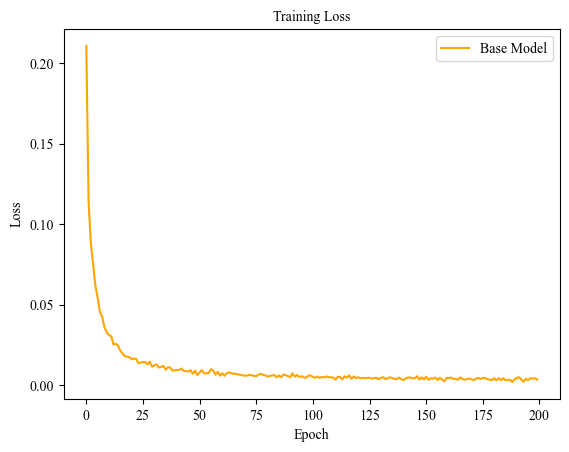

In [2615]:
font = {'family': 'Times New Roman',
        'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_Conventional_losses[0:200], color = 'orange', label = 'Base Model')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})
plt.savefig('original_loss.png')
plt.show()

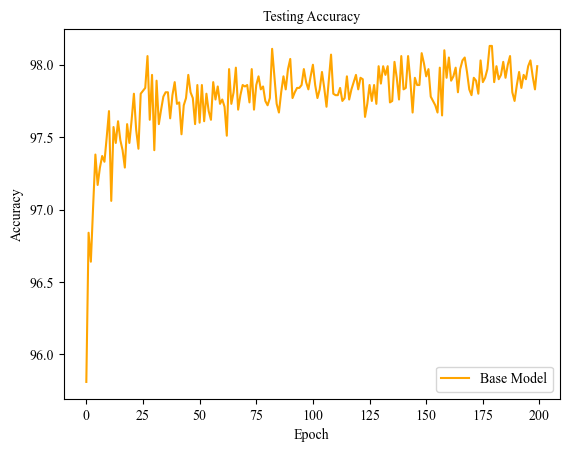

In [2616]:
font = {'family': 'Times New Roman',
        'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_Conventional_acc[0:200], color = 'orange', label = 'Base Model')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('original_acc.png')  
plt.show()

In [7]:
# testing
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for images, labels in testLoader:  
        
        images = images.reshape(-1, 784)
        
        outputs = model_2_Conventional(images)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 97.77


In [1886]:
# testing

numberVoting = 1

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for count in range(numberVoting):
        
        images = samples.reshape(-1, 784)
        
        outputs = model_2_Conventional(images)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        print(predictions)
        print(labels)
        print('-------------')
        
        print(100.0 * (numberCorrect) / numberSamples)
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

tensor([7, 4, 5, 7, 5, 7, 9, 6, 0, 2, 7, 9, 0, 0, 0, 8, 0, 8, 2, 8, 2, 8, 8, 4])
tensor([7, 4, 5, 7, 5, 0, 9, 6, 0, 2, 7, 9, 0, 0, 0, 8, 0, 8, 2, 8, 2, 8, 8, 4])
-------------
95.83333333333333
accuracy = 95.83333333333333


In [26]:
# testing

Test = copy.deepcopy(model_2_Conventional)

numberOfVoting = 1

with torch.no_grad():
    #for z in range(10):
        numberCorrect = 0
        numberSamples = 0
        #inference_1Bit_Bipolar_4vote = []
        #inference_Bit_Unipolar_4vote = []
        for i, (images, labels) in enumerate(testLoader):  

            samples = torch.zeros(24, 1, 28, 28)

            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            samples = torch.gt(images, referenceTrainData).float()

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)


            for k in range(numberOfVoting):
                referenceWeights_1 = 2 * torch.rand(500, 784)/50 - 1
                referenceWeights_2 = 2 * torch.rand(10, 500)/50 - 1
                referenceBias_1 = 2 * torch.rand(500)/50 - 1
                referenceBias_2 = 2 * torch.rand(10)/50 - 1

                Test.linear_1.weight.data = torch.ge(model_2_Conventional.linear_1.weight.data, referenceWeights_1).float()
                Test.linear_2.weight.data = torch.ge(model_2_Conventional.linear_2.weight.data, referenceWeights_2).float()
                Test.linear_1.bias.data = torch.ge(model_2_Conventional.linear_1.bias.data, referenceBias_1).float()
                Test.linear_2.bias.data = torch.ge(model_2_Conventional.linear_2.bias.data, referenceBias_2).float()

            images = samples.reshape(-1, 784)

            outputs = Test(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            #print(100.0 * (numberCorrect) / numberSamples)

            if i >= 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples
        #inference_1Bit_Bipolar_4vote.append(accuracy)
        #inference_Bit_Unipolar_4vote.append(accuracy)
        print(f'accuracy = {accuracy}')

accuracy = 9.795673076923077


In [25]:
# testing

Test = copy.deepcopy(model_2_Conventional)

numberOfVoting = 8

with torch.no_grad():
    for z in range(10):
        numberCorrect = 0
        numberSamples = 0
        #inference_1Bit_Bipolar_4vote = []
        #inference_4Bit_Bipolar_4vote = []
        inference_8Bit_Bipolar_4vote = []
        for i, (images, labels) in enumerate(testLoader):  

            samples = torch.zeros(24, 1, 28, 28)

            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            samples = 2 * torch.gt(images, referenceTrainData).float() - 1

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)


            for k in range(numberOfVoting):
                referenceWeights_1 = 2 * torch.rand(500, 784) - 1
                referenceWeights_2 = 2 * torch.rand(10, 500) - 1
                referenceBias_1 = 2 * torch.rand(500) - 1
                referenceBias_2 = 2 * torch.rand(10) - 1

                count_1 = torch.add( torch.ge(model_2_Conventional.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(model_2_Conventional.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(model_2_Conventional.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(model_2_Conventional.linear_2.bias.data, referenceBias_2).float(), count_4)

            Test.linear_1.weight.data = 2 * torch.div(count_1, numberOfVoting) - 1
            Test.linear_2.weight.data = 2 * torch.div(count_2, numberOfVoting) - 1
            Test.linear_1.bias.data = 2 * torch.div(count_3, numberOfVoting) - 1
            Test.linear_2.bias.data = 2 * torch.div(count_4, numberOfVoting) - 1

            images = samples.reshape(-1, 784)

            outputs = Test(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            #print(100.0 * (numberCorrect) / numberSamples)

            if i >= 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples
        #inference_1Bit_Bipolar_4vote.append(accuracy)
        #inference_4Bit_Bipolar_4vote.append(accuracy)
        inference_8Bit_Bipolar_4vote.append(accuracy)
        print(f'accuracy = {accuracy}')

KeyboardInterrupt: 

In [30]:
# MODEL _ 2 _ 5
# Bipolar
# bitwidth = 8
# Voting Mechansim = Off

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, divide_1, divide_2, divide_3, divide_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:
            for k in range(numberOfVoting):
                referenceWeights_1 = 2 * torch.rand(self.hiddenLayersSize, self.inputSize)/divide_1 - 1
                referenceWeights_2 = 2 * torch.rand(self.numberClasses, self.hiddenLayersSize)/divide_2 - 1
                referenceBias_1 = 2 * torch.rand(self.hiddenLayersSize)/divide_3 - 1
                referenceBias_2 = 2 * torch.rand(self.numberClasses)/divide_4 - 1
                
                #min_val_weight_1 = self.linear_1.weight.data.min()
                #max_val_weight_1 = self.linear_1.weight.data.max()
                #min_val_weight_2 = self.linear_2.weight.data.min()
                #max_val_weight_2 = self.linear_2.weight.data.max()
                #min_val_bias_1 = self.linear_1.bias.data.min()
                #max_val_bias_1 = self.linear_1.bias.data.max()
                #min_val_bias_2 = self.linear_2.bias.data.min()
                #max_val_bias_2 = self.linear_2.bias.data.max()
                
                #referenceWeights_1 = torch.empty_like(referenceWeights_1).uniform_(min_val_weight_1, max_val_weight_1)
                #referenceWeights_2 = torch.empty_like(referenceWeights_2).uniform_(min_val_weight_2, max_val_weight_2)
                #referenceBias_1 = torch.empty_like(referenceBias_1).uniform_(min_val_bias_1, max_val_bias_1)
                #referenceBias_2 = torch.empty_like(referenceBias_2).uniform_(min_val_bias_2, max_val_bias_2)
                
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = (2 * torch.div(count_1, numberOfVoting).float()) - 1
            self.linear_2.weight.data = (2 * torch.div(count_2, numberOfVoting).float()) - 1
            self.linear_1.bias.data = (2 * torch.div(count_3, numberOfVoting).float()) - 1
            self.linear_2.bias.data = (2 * torch.div(count_4, numberOfVoting).float()) - 1

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = -1.0
        output = self.linear_2(output)
        return output
    
model_2_5 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_5_losses = []
model_2_5_acc = []

In [36]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_5.parameters(), lr =  7e-8)

# training loop
n_total_steps = len(trainLoader)

numberOfVoting = 8

for epoch in range(10):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        samples = 2 * torch.div(dataCount, numberOfVoting) - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_5(samples, 0, 0, 8, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        #print(model_2_5.linear_1.weight.data[0][0:20])
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(model_2_5.linear_1.weight.data[0][0:20])    
        
        if loss.item() < 0.0003:
            print(f'{loss.item():.4f}')
        
        if (i+1) % 2500 == 0:
            model_2_5_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{10}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):    

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            dataCount = torch.zeros(24, 1, 28, 28)

            for k in range(numberOfVoting):
                referenceTrainData = torch.rand(24, 1, 28, 28)
                dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)

            samples = 2 * torch.div(dataCount, numberOfVoting) - 1

            samples = samples.reshape(-1, 784)

            outputs = model_2_5(samples, 0, 1, 8, 1, 1, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z >= 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_5_acc.append(accuracy)

epoch 1/10, step 2500 / 2500, loss = 0.3556
accuracy = 88.83213141025641
epoch 2/10, step 2500 / 2500, loss = 0.3525
accuracy = 89.3729967948718
epoch 3/10, step 2500 / 2500, loss = 0.3532
accuracy = 88.90224358974359
epoch 4/10, step 2500 / 2500, loss = 0.3521
accuracy = 88.85216346153847
epoch 5/10, step 2500 / 2500, loss = 0.3587
accuracy = 88.80208333333333
epoch 6/10, step 2500 / 2500, loss = 0.3535
accuracy = 89.30288461538461
epoch 7/10, step 2500 / 2500, loss = 0.3543
accuracy = 89.22275641025641
epoch 8/10, step 2500 / 2500, loss = 0.3573
accuracy = 88.99238782051282
epoch 9/10, step 2500 / 2500, loss = 0.3578
accuracy = 89.0625
epoch 10/10, step 2500 / 2500, loss = 0.3561
accuracy = 89.05248397435898


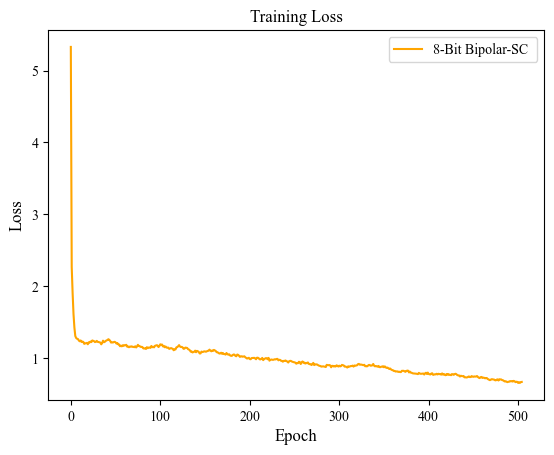

In [2532]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_5_losses, color = 'orange', label = '8-Bit Bipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('8b_1v_B_loss.png')  
plt.show()

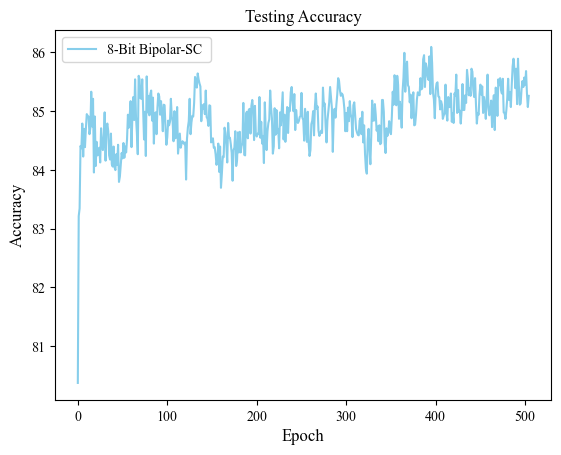

In [2533]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_5_acc, color = 'skyblue', label = '8-Bit Bipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('8b_1v_B_acc.png')  
plt.show()

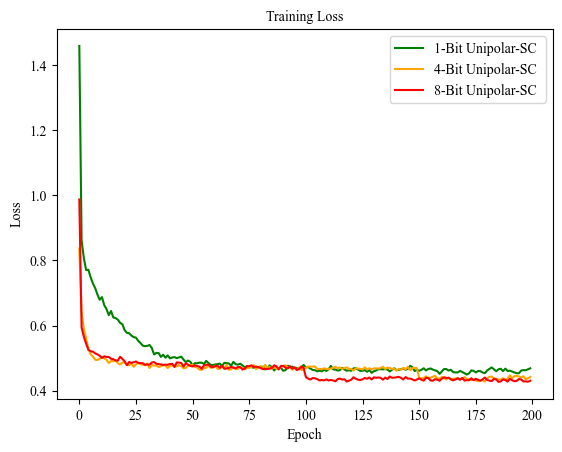

In [2606]:
font = {'family': 'Times New Roman', 'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_15_losses[0:200], color = 'green', label = '1-Bit Unipolar-SC')
plt.plot(model_2_1_losses[0:200], color = 'orange', label = '4-Bit Unipolar-SC ')
plt.plot(model_2_4_losses[0:200], color = 'red', label = '8-Bit Unipolar-SC ')

plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman', 'size' : 10})

plt.savefig('Unipolar_Loss_Comparison.png')  
plt.show()

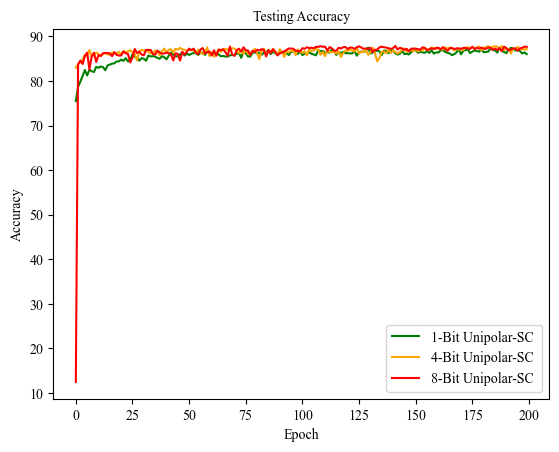

In [2607]:
font = {'family': 'Times New Roman', 'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_15_acc[0:200], color = 'green', label = '1-Bit Unipolar-SC')
plt.plot(model_2_1_acc[0:200], color = 'orange', label = '4-Bit Unipolar-SC ')
plt.plot(model_2_4_acc[0:200], color = 'red', label = '8-Bit Unipolar-SC ')

plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman', 'size' : 10})

plt.savefig('Unipolar_Acc_Comparison.png')  
plt.show()

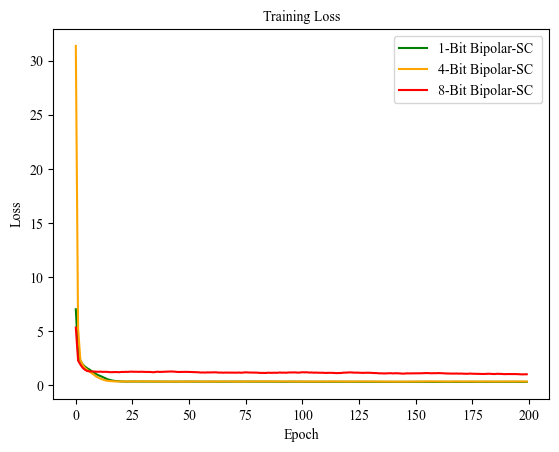

In [2608]:
font = {'family': 'Times New Roman', 'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_16_losses[0:200], color = 'green', label = '1-Bit Bipolar-SC')
plt.plot(model_2_2_losses[0:200], color = 'orange', label = '4-Bit Bipolar-SC ')
plt.plot(model_2_5_losses[0:200], color = 'red', label = '8-Bit Bipolar-SC ')

plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman', 'size' : 10})

plt.savefig('Bipolar_Loss_Comparison.png')  
plt.show()

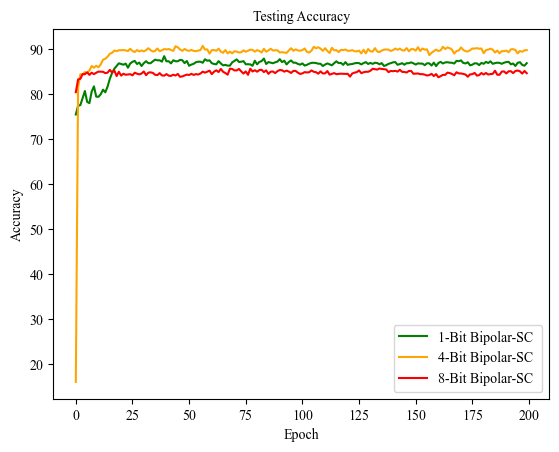

In [2609]:
font = {'family': 'Times New Roman', 'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_16_acc[0:200], color = 'green', label = '1-Bit Bipolar-SC')
plt.plot(model_2_2_acc[0:200], color = 'orange', label = '4-Bit Bipolar-SC ')
plt.plot(model_2_5_acc[0:200], color = 'red', label = '8-Bit Bipolar-SC ')

plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman', 'size' : 10})

plt.savefig('Bipolar_Acc_Comparison.png')  
plt.show()

C:\Users\babak\AppData\Local\Temp\ipykernel_19776\4265599213.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticks(), fontdict = tick_font)
C:\Users\babak\AppData\Local\Temp\ipykernel_19776\4265599213.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticks(), fontdict = tick_font)
C:\Users\babak\AppData\Local\Temp\ipykernel_19776\4265599213.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticks(), fontdict = tick_font)
C:\Users\babak\AppData\Local\Temp\ipykernel_19776\4265599213.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticks(), fontdict = tick_font)
C:\Users\babak\AppData\Local\Temp\ipykernel_19776\4265599213.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_

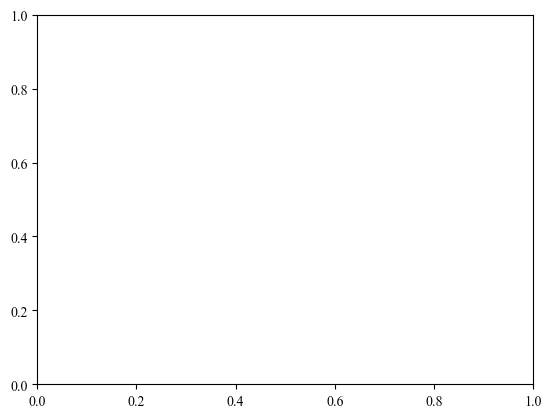

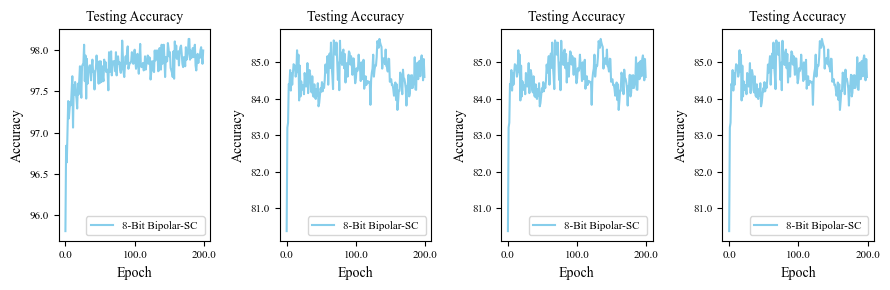

In [2593]:
import matplotlib.image as mpimg

font = {'family': 'Times New Roman', 'size': '10'}
tick_font = {'family': 'Times New Roman', 'size': '8'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

fig, axs = plt.subplots(1, 4)

fig.set_size_inches(9,3)

#fig.subplots_adjust(hspace=0.1, wspace=0.1)

axs[0].plot(model_2_Conventional_acc[0:200], color = 'skyblue', label = '8-Bit Bipolar-SC ')
axs[0].set_xlabel('Epoch', fontdict=font)
axs[0].set_ylabel('Accuracy', fontdict=font)
axs[0].set_title('Testing Accuracy', fontdict=font)
axs[0].set_xticklabels(axs[0].get_xticks(), fontdict = tick_font)
axs[0].set_yticklabels(axs[0].get_yticks(), fontdict = tick_font)
axs[0].legend(prop={'family': 'Times New Roman','size' : 8})

axs[1].plot(model_2_5_acc[0:200], color = 'skyblue', label = '8-Bit Bipolar-SC ')
axs[1].set_xlabel('Epoch', fontdict=font)
axs[1].set_ylabel('Accuracy', fontdict=font)
axs[1].set_title('Testing Accuracy', fontdict=font)
axs[1].set_xticklabels(axs[1].get_xticks(), fontdict = tick_font)
axs[1].set_yticklabels(axs[1].get_yticks(), fontdict = tick_font)
axs[1].legend(prop={'family': 'Times New Roman','size' : 8})

axs[2].plot(model_2_5_acc[0:200], color = 'skyblue', label = '8-Bit Bipolar-SC ')
axs[2].set_xlabel('Epoch', fontdict=font)
axs[2].set_ylabel('Accuracy', fontdict=font)
axs[2].set_title('Testing Accuracy', fontdict=font)
axs[2].set_xticklabels(axs[2].get_xticks(), fontdict = tick_font)
axs[2].set_yticklabels(axs[2].get_yticks(), fontdict = tick_font)
axs[2].legend(prop={'family': 'Times New Roman','size' : 8})

axs[3].plot(model_2_5_acc[0:200], color = 'skyblue', label = '8-Bit Bipolar-SC ')
axs[3].set_xlabel('Epoch', fontdict=font)
axs[3].set_ylabel('Accuracy', fontdict=font)
axs[3].set_title('Testing Accuracy', fontdict=font)
axs[3].set_xticklabels(axs[3].get_xticks(), fontdict = tick_font)
axs[3].set_yticklabels(axs[3].get_yticks(), fontdict = tick_font)
axs[3].legend(prop={'family': 'Times New Roman','size' : 8})

plt.tight_layout()
plt.savefig('sample.png')  
plt.show()

In [ ]:
testModel = copy.deepcopy(model_2_5)
trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(testModel.parameters(), lr =  5e-4)

# training loop
n_total_steps = len(trainLoader)

numberOfVoting = 8

for epoch in range(5):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        samples = 2 * torch.div(dataCount, numberOfVoting) - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = testModel(samples, 0, 0, 8, 1, 1, 1, 1)
        print(testModel.linear_1.weight.data[0][0:20])
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(testModel.linear_1.weight.data[0][0:20])    
        if loss.item() < 0.0003:
            print(f'{loss.item():.4f}')
        
        if (i+1) % 2500 == 0:
            print(f'epoch {epoch+1}/{5}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):    

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            dataCount = torch.zeros(24, 1, 28, 28)

            for k in range(numberOfVoting):
                referenceTrainData = torch.rand(24, 1, 28, 28)/20
                dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)

            samples = 2 * torch.div(dataCount, numberOfVoting) - 1

            samples = samples.reshape(-1, 784)

            outputs = testModel(samples, 0, 1, 8, 0.9, 0.9, 0.9, 0.9)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z >= 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')

In [1854]:
# testing
testLoader = torch.utils.data.DataLoader(dataset = testDataset, batch_size=24, shuffle=True)

testModel = copy.deepcopy(model_2_5)
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader):    
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/50
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = 2 * torch.gt(images, referenceTrainData).float() - 1
        
        samples = samples.reshape(-1, 784)
        
        outputs = testModel(samples, 0, 1, 8, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        #print(100.0 * (numberCorrect) / numberSamples)
        
        if i >= 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 59.98597756410256


In [1145]:
# MODEL _ 2 _ 6
# Unipolar
# bitwidth = 16
# Voting Mechansim = Off

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, threshhold, divide_1, divide_2, divide_3, divide_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = torch.rand(self.hiddenLayersSize, self.inputSize)/divide_1
                referenceWeights_2 = torch.rand(self.numberClasses, self.hiddenLayersSize)/divide_2
                referenceBias_1 = torch.rand(self.hiddenLayersSize)/divide_3
                referenceBias_2 = torch.rand(self.numberClasses)/divide_4
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = torch.div(count_1, numberOfVoting)
            self.linear_2.weight.data = torch.div(count_2, numberOfVoting)
            self.linear_1.bias.data = torch.div(count_3, numberOfVoting)
            self.linear_2.bias.data = torch.div(count_4, numberOfVoting)

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = 0.0
        output = self.linear_2(output)
        return output
    
model_2_6 = NeuralNetwork(inputSize, 500, numberClasses)

In [1657]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_6.parameters(), lr =  5e-8)

# training loop
n_total_steps = len(trainLoader)

flag = 0

for epoch in range(40):
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.gt(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_6(samples, 0, 0, 16, 2, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.01:
            print(f'{loss.item():.4f}')

            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model.pth')
            
        if loss.item() < 0.0003:
            print(f'{loss.item():.4f}')
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model_2_4.pth')
        
        #if (i+1) % 100 == 0:
            #print(model_2_3.linear_1.weight.data[0])
            #print('-------------------------------')
        
        if (i+1) % 2500 == 0:
            print(f'epoch {epoch+1}/{40}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')

epoch 1/40, step 2500 / 2500, loss = 0.6041
epoch 2/40, step 2500 / 2500, loss = 0.7103
epoch 3/40, step 2500 / 2500, loss = 0.3879
epoch 4/40, step 2500 / 2500, loss = 1.2816
epoch 5/40, step 2500 / 2500, loss = 0.3086
epoch 6/40, step 2500 / 2500, loss = 0.8221
0.0083
epoch 7/40, step 2500 / 2500, loss = 0.3568
epoch 8/40, step 2500 / 2500, loss = 0.7794
epoch 9/40, step 2500 / 2500, loss = 0.2818
epoch 10/40, step 2500 / 2500, loss = 0.6071
epoch 11/40, step 2500 / 2500, loss = 0.3193
epoch 12/40, step 2500 / 2500, loss = 0.7158
epoch 13/40, step 2500 / 2500, loss = 0.3133
epoch 14/40, step 2500 / 2500, loss = 0.8292
epoch 15/40, step 2500 / 2500, loss = 0.5993
epoch 16/40, step 2500 / 2500, loss = 0.8027
epoch 17/40, step 2500 / 2500, loss = 0.9359
epoch 18/40, step 2500 / 2500, loss = 0.6519
0.0100
epoch 19/40, step 2500 / 2500, loss = 0.9849
epoch 20/40, step 2500 / 2500, loss = 0.5454
epoch 21/40, step 2500 / 2500, loss = 0.1892
epoch 22/40, step 2500 / 2500, loss = 0.2669
epoch

In [1661]:
# testing
testModel = copy.deepcopy(model_2_6)
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader): 
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/10
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = torch.ge(images, referenceTrainData).float()
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 16, 2, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 85.02604166666667


In [1882]:
examples = iter(testLoader)
samples, labels = next(examples)
testSamples = torch.zeros_like(samples)

In [1674]:
# testing

test_model = copy.deepcopy(model_2_6)

batchSize = 24

numberOfImages = batchSize

count_1 = torch.zeros(300, 784)
count_2 = torch.zeros(10, 300)

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    numberVoting = 4
    stochasticPrecision = 1
    collection = torch.zeros(batchSize, numberVoting)
    for count in range(numberVoting):
        
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = torch.gt(samples, referenceTrainData).float()
        
        referenceWeights_1 = torch.rand(500, 784)*1.01
        referenceWeights_2 = torch.rand(10, 500)*1.01
        referenceBias_1 = torch.rand(500)*1
        referenceBias_2 = torch.rand(10)*1
        
        test_model.linear_1.weight.data = torch.ge(model_2_6.linear_1.weight.data, referenceWeights_1).float()
        test_model.linear_2.weight.data = torch.ge(model_2_6.linear_2.weight.data, referenceWeights_2).float()
        test_model.linear_1.bias.data = torch.ge(model_2_6.linear_1.bias.data, referenceBias_1).float()
        test_model.linear_2.bias.data = torch.ge(model_2_6.linear_2.bias.data, referenceBias_2).float()
        
        images = testSamples.reshape(-1, 784)
        
        outputs = test_model(images, 0, 1, 8, 2, 1, 1, 1, 1)
        
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        for counter in range(batchSize):
            collection[counter][count] = predictions[counter]
        
        print(predictions)
        print(labels)
        print('-------------')
    #accuracy = 100.0 * numberCorrect / (numberVoting * numberOfImages)
    
    #print(f'accuracy = {accuracy}')
    
    results = torch.zeros(batchSize)
    for i in range(batchSize):
        unique_elements, counts = torch.unique(collection[i], return_counts=True)
        max_count_index = torch.argmax(counts)

        element_with_max_count = unique_elements[max_count_index]
        max_count = counts[max_count_index]

        results[i] = element_with_max_count.item()
        
    accuracy = 0
    for i in range(batchSize):
        accuracy += (results[i] == labels[i]).sum().item()
    print(results.int())
    print(labels)
    print('---------')
    print((accuracy/batchSize)*100)

tensor([7, 1, 8, 4, 6, 2, 1, 7, 3, 6, 3, 2, 3, 1, 0, 6, 7, 4, 5, 9, 7, 4, 7, 0])
tensor([7, 1, 9, 4, 4, 0, 1, 7, 3, 6, 3, 2, 3, 1, 8, 6, 9, 4, 5, 9, 7, 4, 9, 0])
-------------
tensor([7, 1, 8, 4, 4, 2, 1, 7, 3, 6, 3, 2, 3, 1, 8, 6, 7, 4, 5, 9, 7, 4, 9, 0])
tensor([7, 1, 9, 4, 4, 0, 1, 7, 3, 6, 3, 2, 3, 1, 8, 6, 9, 4, 5, 9, 7, 4, 9, 0])
-------------
tensor([7, 1, 8, 4, 6, 2, 1, 7, 0, 6, 3, 2, 3, 1, 8, 6, 7, 4, 5, 9, 7, 4, 9, 0])
tensor([7, 1, 9, 4, 4, 0, 1, 7, 3, 6, 3, 2, 3, 1, 8, 6, 9, 4, 5, 9, 7, 4, 9, 0])
-------------
tensor([7, 1, 8, 4, 4, 2, 1, 7, 0, 6, 3, 2, 3, 1, 0, 6, 7, 4, 5, 9, 7, 4, 9, 0])
tensor([7, 1, 9, 4, 4, 0, 1, 7, 3, 6, 3, 2, 3, 1, 8, 6, 9, 4, 5, 9, 7, 4, 9, 0])
-------------
tensor([7, 1, 8, 4, 4, 2, 1, 7, 0, 6, 3, 2, 3, 1, 0, 6, 7, 4, 5, 9, 7, 4, 9, 0],
       dtype=torch.int32)
tensor([7, 1, 9, 4, 4, 0, 1, 7, 3, 6, 3, 2, 3, 1, 8, 6, 9, 4, 5, 9, 7, 4, 9, 0])
---------
79.16666666666666


In [1304]:
# MODEL _ 2 _ 7

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting):
        
        count_1 = torch.zeros(300, 784)
        count_2 = torch.zeros(10, 300)
        count_3 = torch.zeros(300)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = 2 * torch.rand(self.hiddenLayersSize, self.inputSize) - 1
                referenceWeights_2 = 2 * torch.rand(self.numberClasses, self.hiddenLayersSize) - 1
                referenceBias_1 = 2 * torch.rand(self.hiddenLayersSize) - 1
                referenceBias_2 = 2 * torch.rand(self.numberClasses) - 1
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = 2 * torch.div(count_1, numberOfVoting) - 1
            self.linear_2.weight.data = 2 * torch.div(count_2, numberOfVoting) - 1
            self.linear_1.bias.data = 2 * torch.div(count_3, numberOfVoting) - 1
            self.linear_2.bias.data = 2 * torch.div(count_4, numberOfVoting) - 1

            count_1 = torch.zeros(300, 784)
            count_2 = torch.zeros(10, 300)
            count_3 = torch.zeros(300)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 300)
            for i in range(len(output)):
                for j in range(300):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = 0.0
        output = self.linear_2(output)
        return output
    
model_2_7 = NeuralNetwork(inputSize, 300, numberClasses)

In [1307]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_7.parameters(), lr =  5e-4)

# training loop
n_total_steps = len(trainLoader)

flag = 0

for epoch in range(5):
    if flag == 1:
        break
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = 2 * torch.gt(images, referenceTrainData).float() - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_7(samples, 0, 0, 8)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.01:
            print(f'{loss.item():.4f}')
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model.pth')
            
        if loss.item() < 0.001:
            print(f'{loss.item():.4f}')
            flag = 1
            break
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model_2_4.pth')
        
        #if (i+1) % 100 == 0:
            #print(model_2_3.linear_1.weight.data[0])
            #print('-------------------------------')
        
        if (i+1) % 2500 == 0:
            print(f'epoch {epoch+1}/{5}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')

0.0060
0.0085
0.0094
0.0022
epoch 1/5, step 2500 / 2500, loss = 1.0166
0.0009
0.0009


In [1297]:
# testing

test_model = copy.deepcopy(model_2_7)

batchSize = 24

numberOfImages = batchSize

count_1 = torch.zeros(300, 784)
count_2 = torch.zeros(10, 300)

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    numberVoting = 4
    stochasticPrecision = 1
    collection = torch.zeros(batchSize, numberVoting)
    for count in range(numberVoting):
        
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = 2 * torch.gt(samples, referenceTrainData).float() - 1
        
        #referenceWeights_1 = 2 * torch.rand(300, 784) - 1
        #referenceWeights_2 = 2 * torch.rand(10, 300) - 1
        #referenceBias_1 = 2 * torch.rand(300) - 1
        #referenceBias_2 = 2 * torch.rand(10) - 1
        
        #test_model.linear_1.weight.data = 2 * torch.ge(model_2_7.linear_1.weight.data, referenceWeights_1).float() - 1
        #test_model.linear_2.weight.data = 2 * torch.ge(model_2_7.linear_2.weight.data, referenceWeights_2).float() - 1
        #test_model.linear_1.bias.data = 2 * torch.ge(model_2_7.linear_1.bias.data, referenceBias_1).float() - 1
        #test_model.linear_2.bias.data = 2 * torch.ge(model_2_7.linear_2.bias.data, referenceBias_2).float() - 1
        
        images = testSamples.reshape(-1, 784)
        
        outputs = test_model(images, 0, 1, 8)
        
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        for counter in range(batchSize):
            collection[counter][count] = predictions[counter]
        
        print(predictions)
        print(labels)
        print('-------------')
    #accuracy = 100.0 * numberCorrect / (numberVoting * numberOfImages)
    
    #print(f'accuracy = {accuracy}')
    
    results = torch.zeros(batchSize)
    for i in range(batchSize):
        unique_elements, counts = torch.unique(collection[i], return_counts=True)
        max_count_index = torch.argmax(counts)

        element_with_max_count = unique_elements[max_count_index]
        max_count = counts[max_count_index]

        results[i] = element_with_max_count.item()
        
    accuracy = 0
    for i in range(batchSize):
        accuracy += (results[i] == labels[i]).sum().item()
    print(results.int())
    print(labels)
    print('---------')
    print((accuracy/batchSize)*100)

tensor([8, 2, 6, 5, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
tensor([8, 2, 8, 5, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
-------------
tensor([8, 2, 6, 8, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
tensor([8, 2, 8, 5, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
-------------
tensor([8, 2, 6, 5, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
tensor([8, 2, 8, 5, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
-------------
tensor([8, 2, 6, 8, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
tensor([8, 2, 8, 5, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
-------------
tensor([8, 2, 6, 5, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7],
       dtype=torch.int32)
tensor([8, 2, 8, 5, 3, 3, 2, 3, 2, 4, 1, 6, 5, 8, 9, 7, 0, 9, 8, 6, 5, 1, 8, 7])
---------
95.83333333333334


In [1319]:
# testing
testModel = copy.deepcopy(model_2_7)
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader): 
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = 2 * torch.gt(images, referenceTrainData).float() - 1
        
        images = images.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 8)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        #print(100.0 * (numberCorrect) / numberSamples)
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 85.96754807692308


In [1350]:
# MODEL _ 2 _ 8

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = 2 * torch.rand(self.hiddenLayersSize, self.inputSize) - 1
                referenceWeights_2 = 2 * torch.rand(self.numberClasses, self.hiddenLayersSize) - 1
                referenceBias_1 = 2 * torch.rand(self.hiddenLayersSize) - 1
                referenceBias_2 = 2 * torch.rand(self.numberClasses) - 1
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = 2 * torch.div(count_1, numberOfVoting) - 1
            self.linear_2.weight.data = 2 * torch.div(count_2, numberOfVoting) - 1
            self.linear_1.bias.data = 2 * torch.div(count_3, numberOfVoting) - 1
            self.linear_2.bias.data = 2 * torch.div(count_4, numberOfVoting) - 1

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = 0.0
        output = self.linear_2(output)
        return output
    
model_2_8 = NeuralNetwork(inputSize, 500, numberClasses)

In [1860]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_8.parameters(), lr =  5e-10)

# training loop
n_total_steps = len(trainLoader)

flag = 0

for epoch in range(5):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        samples = 2 * torch.div(dataCount, numberOfVoting) - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_8(samples, 0, 0, 16)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.01:
            print(f'{loss.item():.5f}')
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model.pth')
            
        if loss.item() < 0.00003:
            print(f'{loss.item():.6f}')
            #flag = 1
            #break
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model_2_4.pth')
        
        #if (i+1) % 100 == 0:
            #print(model_2_3.linear_1.weight.data[0])
            #print('-------------------------------')
        
        if (i+1) % 2500 == 0:
            print(f'epoch {epoch+1}/{5}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')

epoch 1/5, step 2500 / 2500, loss = 0.31364
epoch 2/5, step 2500 / 2500, loss = 0.31370
epoch 3/5, step 2500 / 2500, loss = 0.31632
epoch 4/5, step 2500 / 2500, loss = 0.31645
epoch 5/5, step 2500 / 2500, loss = 0.31397


In [1861]:
# testing
testModel = copy.deepcopy(model_2_8)
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader): 
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = 2 * torch.gt(images, referenceTrainData).float() - 1
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 16)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        #print(100.0 * (numberCorrect) / numberSamples)
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 90.02403846153847


In [1729]:
# testing

test_model = copy.deepcopy(model_2_8)

batchSize = 24

numberOfImages = batchSize

count_1 = torch.zeros(300, 784)
count_2 = torch.zeros(10, 300)

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    numberVoting = 16
    stochasticPrecision = 1
    collection = torch.zeros(batchSize, numberVoting)
    for count in range(numberVoting):
        
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = 2 * torch.gt(samples, referenceTrainData).float() - 1
        
        #referenceWeights_1 = torch.randn(500, 784)
        #referenceWeights_2 = torch.randn(10, 500)
        #referenceBias_1 = torch.randn(500)
        #referenceBias_2 = torch.randn(10)
        
        #test_model.linear_1.weight.data = 2 * torch.ge(model_2_8.linear_1.weight.data, referenceWeights_1).float() - 1
        #test_model.linear_2.weight.data = 2 * torch.ge(model_2_8.linear_2.weight.data, referenceWeights_2).float() - 1
        #test_model.linear_1.bias.data = 2 * torch.ge(model_2_8.linear_1.bias.data, referenceBias_1).float() - 1
        #test_model.linear_2.bias.data = 2 * torch.ge(model_2_8.linear_2.bias.data, referenceBias_2).float() - 1
        
        images = testSamples.reshape(-1, 784)
        
        outputs = test_model(images, 0, 1, 8)
        
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        for counter in range(batchSize):
            collection[counter][count] = predictions[counter]
        
        #print(predictions)
        #print(labels)
        #print('-------------')
    
    results = torch.zeros(batchSize)
    for i in range(batchSize):
        unique_elements, counts = torch.unique(collection[i], return_counts=True)
        max_count_index = torch.argmax(counts)

        element_with_max_count = unique_elements[max_count_index]
        max_count = counts[max_count_index]

        results[i] = element_with_max_count.item()
        
    accuracy = 0
    for i in range(batchSize):
        accuracy += (results[i] == labels[i]).sum().item()
    print(results.int())
    print(labels)
    print('---------')
    print((accuracy/batchSize)*100)

tensor([5, 2, 2, 9, 7, 7, 9, 9, 6, 1, 8, 6, 1, 1, 0, 6, 0, 6, 4, 8, 7, 4, 5, 9],
       dtype=torch.int32)
tensor([5, 2, 2, 9, 7, 9, 9, 9, 6, 1, 8, 6, 1, 1, 6, 6, 0, 6, 9, 8, 7, 4, 5, 9])
---------
87.5


In [2094]:
# MODEL _ 2 _ 9
# Bipolar
# bitwidth = 1
# Voting Mechansim = 4

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, threshhold):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:         
            #with torch.no_grad():               
            for k in range(numberOfVoting):
                referenceWeights_1 = 2 * torch.rand(self.hiddenLayersSize, self.inputSize) - 1
                referenceWeights_2 = 2 * torch.rand(self.numberClasses, self.hiddenLayersSize) - 1
                referenceBias_1 = 2 * torch.rand(self.hiddenLayersSize) - 1
                referenceBias_2 = 2 * torch.rand(self.numberClasses) - 1
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = 2 * torch.ge(count_1, threshhold).float() - 1
            self.linear_2.weight.data = 2 * torch.ge(count_2, threshhold).float() - 1
            self.linear_1.bias.data = 2 * torch.ge(count_3, threshhold).float() - 1
            self.linear_2.bias.data = 2 * torch.ge(count_4, threshhold).float() - 1

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            output = torch.ge(output, randomVariables).float()
        output = self.linear_2(output)
        return output
    
model_2_9 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_9_losses =[]
model_2_9_acc = []

In [2099]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_9.parameters(), lr =  7e-6)

# training loop
n_total_steps = len(trainLoader)

flag = 0

for epoch in range(100):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = (2 * torch.ge(images, referenceTrainData).float()) - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_9(samples, 0, 0, 4, 2)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if loss.item() < 0.0003:
            print(f'{loss.item():.6f}')

        
        if (i+1) % 2500 == 0:
            model_2_9_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{100}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20

            samples = 2 * torch.ge(images, referenceTrainData).float() - 1

            images = samples.reshape(-1, 784)

            outputs = model_2_9(images, 0, 1, 4, 2)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_9_acc.append(accuracy)

epoch 1/100, step 2500 / 2500, loss = 0.61937
accuracy = 81.87099358974359
epoch 2/100, step 2500 / 2500, loss = 0.62160
accuracy = 82.09134615384616
epoch 3/100, step 2500 / 2500, loss = 0.62463
accuracy = 81.640625
epoch 4/100, step 2500 / 2500, loss = 0.61928
accuracy = 81.87099358974359
epoch 5/100, step 2500 / 2500, loss = 0.62220
accuracy = 81.87099358974359
epoch 6/100, step 2500 / 2500, loss = 0.61969
accuracy = 81.80088141025641
epoch 7/100, step 2500 / 2500, loss = 0.62089
accuracy = 81.40024038461539
epoch 8/100, step 2500 / 2500, loss = 0.62042
accuracy = 81.7608173076923
epoch 9/100, step 2500 / 2500, loss = 0.62167
accuracy = 81.81089743589743
epoch 10/100, step 2500 / 2500, loss = 0.62284
accuracy = 81.82091346153847
epoch 11/100, step 2500 / 2500, loss = 0.61836
accuracy = 81.94110576923077
epoch 12/100, step 2500 / 2500, loss = 0.62162
accuracy = 81.78084935897436
epoch 13/100, step 2500 / 2500, loss = 0.61957
accuracy = 82.01121794871794
epoch 14/100, step 2500 / 2500

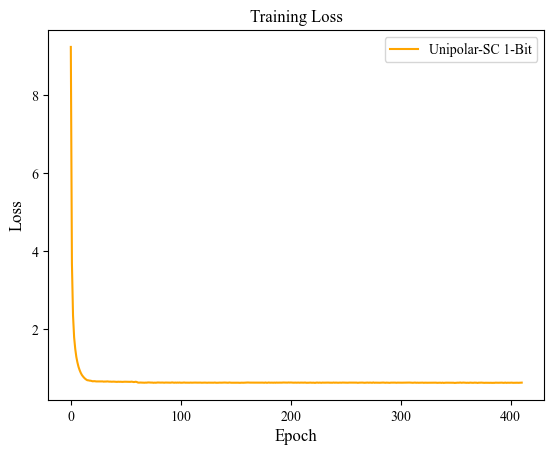

In [2500]:
font = {'family': 'Times New Roman',
        'size': '12'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_9_losses, color = 'orange', label = 'Unipolar-SC 1-Bit')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.show()

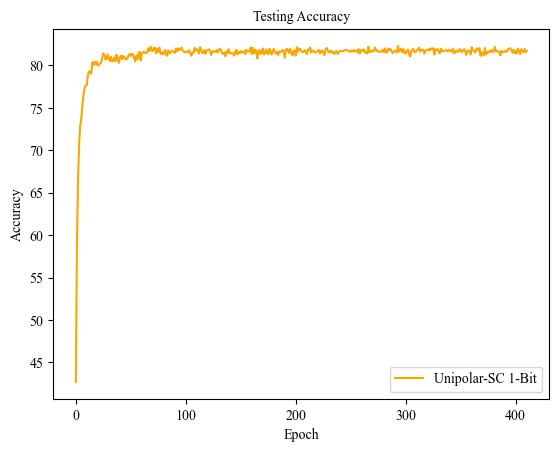

In [2618]:
font = {'family': 'Times New Roman',
        'size': '10'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_9_acc, color = 'orange', label = 'Unipolar-SC 1-Bit')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.show()

In [2114]:
# MODEL _ 2 _ 10
# Unipolar
# bitwidth = 1
# Voting Mechansim = 8

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, threshhold, d_1, d_2, d_3, d_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:              
            for k in range(numberOfVoting):
                referenceWeights_1 = torch.rand(self.hiddenLayersSize, self.inputSize)/d_1
                referenceWeights_2 = torch.rand(self.numberClasses, self.hiddenLayersSize)/d_2
                referenceBias_1 = torch.rand(self.hiddenLayersSize)/d_3
                referenceBias_2 = torch.rand(self.numberClasses)/d_4
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = torch.ge(count_1, threshhold).float()
            self.linear_2.weight.data = torch.ge(count_2, threshhold).float()
            self.linear_1.bias.data = torch.ge(count_3, threshhold).float()
            self.linear_2.bias.data = torch.ge(count_4, threshhold).float()

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            output = torch.ge(output, randomVariables).float()
        output = self.linear_2(output)
        return output
    
model_2_10 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_10_losses =[]
model_2_10_acc = []

In [2122]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_10.parameters(), lr = 7e-12)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(20):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_10(samples, 0, skipFlag, 8, 4, 50, 50, 50, 50)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.0003:
            print(f'{loss.item():.4f}')

        if (i+1) % 2500 == 0:
            model_2_10_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{20}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')
    
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            samples = torch.zeros(24, 1, 28, 28)

            samples = torch.ge(images, referenceTrainData).float()

            images = samples.reshape(-1, 784)

            outputs = model_2_10(images, 0, 1, 4, 2, 1, 1, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_10_acc.append(accuracy)

epoch 1/20, step 2500 / 2500, loss = 0.40598
accuracy = 88.2411858974359
epoch 2/20, step 2500 / 2500, loss = 0.40019
accuracy = 87.60016025641026
epoch 3/20, step 2500 / 2500, loss = 0.40259
accuracy = 87.90064102564102
epoch 4/20, step 2500 / 2500, loss = 0.40527
accuracy = 87.7704326923077
epoch 5/20, step 2500 / 2500, loss = 0.40221
accuracy = 88.02083333333333
epoch 6/20, step 2500 / 2500, loss = 0.40528
accuracy = 88.11097756410257
epoch 7/20, step 2500 / 2500, loss = 0.40462
accuracy = 88.06089743589743
epoch 8/20, step 2500 / 2500, loss = 0.40324
accuracy = 88.28125
epoch 9/20, step 2500 / 2500, loss = 0.39909
accuracy = 88.05088141025641
epoch 10/20, step 2500 / 2500, loss = 0.40103
accuracy = 88.0108173076923
epoch 11/20, step 2500 / 2500, loss = 0.40503
accuracy = 88.25120192307692
epoch 12/20, step 2500 / 2500, loss = 0.40348
accuracy = 87.9306891025641
epoch 13/20, step 2500 / 2500, loss = 0.40015
accuracy = 87.78044871794872
epoch 14/20, step 2500 / 2500, loss = 0.40254
a

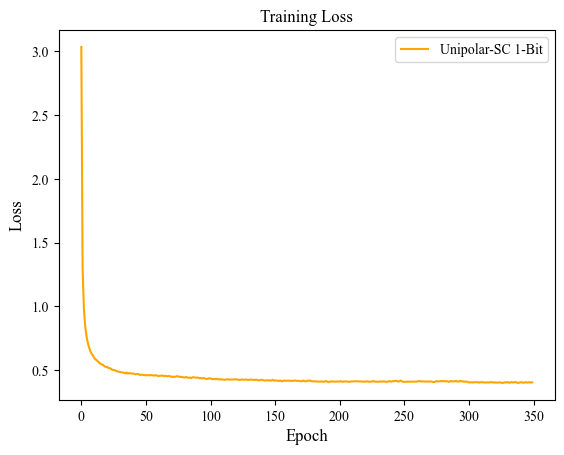

In [2620]:
font = {'family': 'Times New Roman',
        'size': '12'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_10_losses, color = 'orange', label = 'Unipolar-SC 1-Bit')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.show()

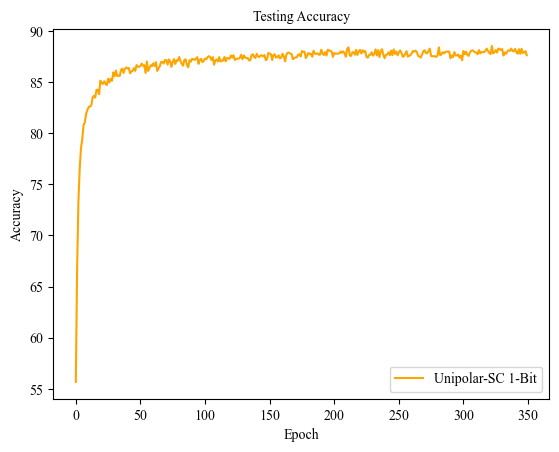

In [2619]:
font = {'family': 'Times New Roman',
        'size': '10'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_10_acc, color = 'orange', label = 'Unipolar-SC 1-Bit')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.show()

In [2460]:
# MODEL _ 2 _ 11
# Bipolar
# bitwidth = 1
# Voting Mechansim = 8

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, threshhold, divide_1, divide_2, divide_3, divide_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                    
            for k in range(numberOfVoting):
                referenceWeights_1 = 2 * (torch.rand(self.hiddenLayersSize, self.inputSize) / divide_1) - 1
                referenceWeights_2 = 2 * (torch.rand(self.numberClasses, self.hiddenLayersSize)/ divide_2) - 1
                referenceBias_1 = 2 * (torch.rand(self.hiddenLayersSize)/ divide_3) - 1
                referenceBias_2 = 2 * (torch.rand(self.numberClasses)/ divide_4) - 1
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = 2 *torch.ge(count_1, threshhold).float() - 1
            self.linear_2.weight.data =2 * torch.ge(count_2, threshhold).float() - 1
            self.linear_1.bias.data = 2 *torch.ge(count_3, threshhold).float() - 1
            self.linear_2.bias.data = 2 *torch.ge(count_4, threshhold).float() - 1

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            output = torch.ge(output, randomVariables).float()
        output = self.linear_2(output)
        return output
    
model_2_11 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_11_losses = []
model_2_11_acc = []

In [2462]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_11.parameters(), lr = 7e-6)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(50):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_11(samples, 0, 0, 8, 4, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.0003:
            print(f'{loss.item():.4f}')
        
        if (i+1) % 2500 == 0:
            model_2_11_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{50}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20

            samples = torch.ge(images, referenceTrainData).float()

            images = samples.reshape(-1, 784)

            outputs = model_2_11(images, 0, 1, 8, 4, 1, 1, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_11_acc.append(accuracy)

epoch 1/50, step 2500 / 2500, loss = 0.6514
accuracy = 79.74759615384616
epoch 2/50, step 2500 / 2500, loss = 0.6546
accuracy = 80.25841346153847
epoch 3/50, step 2500 / 2500, loss = 0.6550
accuracy = 80.24839743589743
epoch 4/50, step 2500 / 2500, loss = 0.6538
accuracy = 79.86778846153847
epoch 5/50, step 2500 / 2500, loss = 0.6507
accuracy = 80.3485576923077
epoch 6/50, step 2500 / 2500, loss = 0.6548
accuracy = 79.9579326923077
epoch 7/50, step 2500 / 2500, loss = 0.6544
accuracy = 80.46875
epoch 8/50, step 2500 / 2500, loss = 0.6551
accuracy = 79.91786858974359
epoch 9/50, step 2500 / 2500, loss = 0.6507
accuracy = 79.9979967948718
epoch 10/50, step 2500 / 2500, loss = 0.6537
accuracy = 80.1983173076923
epoch 11/50, step 2500 / 2500, loss = 0.6541
accuracy = 80.0380608974359
epoch 12/50, step 2500 / 2500, loss = 0.6510
accuracy = 79.90785256410257
epoch 13/50, step 2500 / 2500, loss = 0.6536
accuracy = 80.06810897435898
epoch 14/50, step 2500 / 2500, loss = 0.6558
accuracy = 80.02

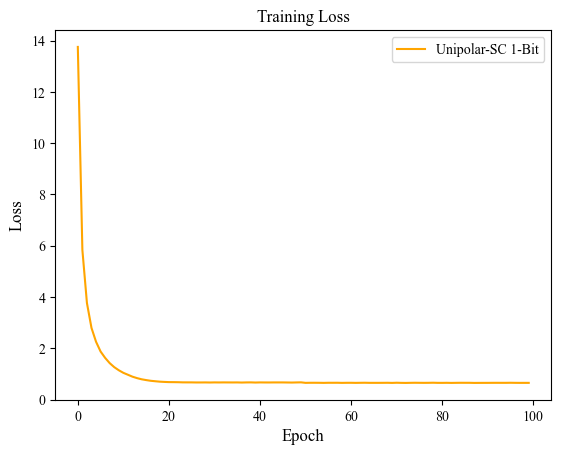

In [2621]:
font = {'family': 'Times New Roman',
        'size': '12'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_11_losses, color = 'orange', label = 'Unipolar-SC 1-Bit')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.show()

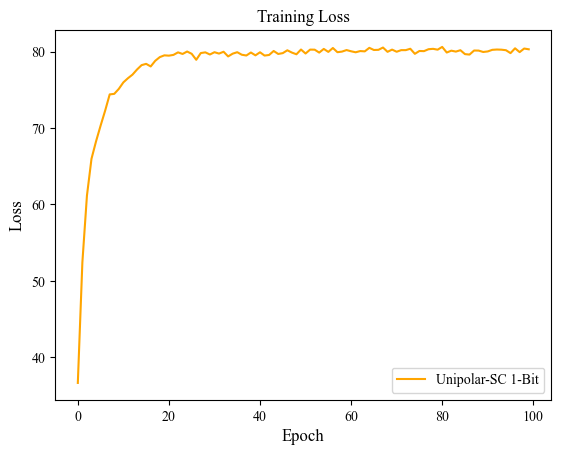

In [2622]:
font = {'family': 'Times New Roman',
        'size': '12'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_11_acc, color = 'orange', label = 'Unipolar-SC 1-Bit')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.show()

In [1682]:
# MODEL _ 2 _ 12
# Bipolar
# bitwidth = 32
# Voting Mechansim = off

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, d_1, d_2, d_3, d_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = (2 * torch.rand(self.hiddenLayersSize, self.inputSize) / d_1) - 1
                referenceWeights_2 = (2 * torch.rand(self.numberClasses, self.hiddenLayersSize) / d_2) - 1
                referenceBias_1 = (2 * torch.rand(self.hiddenLayersSize) / d_3) - 1
                referenceBias_2 = (2 * torch.rand(self.numberClasses) / d_4) - 1
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = 2 * torch.div(count_1, numberOfVoting) - 1
            self.linear_2.weight.data = 2 * torch.div(count_2, numberOfVoting) - 1
            self.linear_1.bias.data = 2 * torch.div(count_3, numberOfVoting) - 1
            self.linear_2.bias.data = 2 * torch.div(count_4, numberOfVoting) - 1

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = -1.0
        output = self.linear_2(output)
        return output
    
model_2_12 = NeuralNetwork(inputSize, 500, numberClasses)

In [1895]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_12.parameters(), lr =  5e-9)

# training loop
n_total_steps = len(trainLoader)

numberOfVoting = 32

for epoch in range(10):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        samples = 2 * torch.div(dataCount, numberOfVoting) - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_12(samples, 0, 0, 32, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.001:
            print(f'{loss.item():.5f}')
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model.pth')
            
        if loss.item() < 0.00003:
            print(f'{loss.item():.6f}')
            #flag = 1
            #break
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model_2_4.pth')
        
        #if (i+1) % 100 == 0:
            #print(model_2_3.linear_1.weight.data[0])
            #print('-------------------------------')
        
        if (i+1) % 2500 == 0:
            print(f'epoch {epoch+1}/{10}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')

epoch 1/10, step 2500 / 2500, loss = 0.33940
epoch 2/10, step 2500 / 2500, loss = 0.34120
epoch 3/10, step 2500 / 2500, loss = 0.33924
epoch 4/10, step 2500 / 2500, loss = 0.34081
epoch 5/10, step 2500 / 2500, loss = 0.34019
epoch 6/10, step 2500 / 2500, loss = 0.34197
epoch 7/10, step 2500 / 2500, loss = 0.34116
epoch 8/10, step 2500 / 2500, loss = 0.34382
epoch 9/10, step 2500 / 2500, loss = 0.34299
epoch 10/10, step 2500 / 2500, loss = 0.34206


In [1896]:
# testing
testModel = copy.deepcopy(model_2_12)
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader): 
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = 2 * torch.gt(images, referenceTrainData).float() - 1
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 32, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        #print(100.0 * (numberCorrect) / numberSamples)
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 89.36298076923077


In [1757]:
# testing

test_model = copy.deepcopy(model_2_12)

batchSize = 24

numberOfImages = batchSize

count_1 = torch.zeros(300, 784)
count_2 = torch.zeros(10, 300)

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    numberVoting = 4
    stochasticPrecision = 1
    collection = torch.zeros(batchSize, numberVoting)
    for count in range(numberVoting):
        
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        testSamples = torch.zeros(24, 1, 28, 28)
        
        testSamples = 2 * torch.gt(samples, referenceTrainData).float() - 1
        
        #referenceWeights_1 = torch.randn(500, 784)
        #referenceWeights_2 = torch.randn(10, 500)
        #referenceBias_1 = torch.randn(500)
        #referenceBias_2 = torch.randn(10)
        
        #test_model.linear_1.weight.data = 2 * torch.ge(model_2_8.linear_1.weight.data, referenceWeights_1).float() - 1
        #test_model.linear_2.weight.data = 2 * torch.ge(model_2_8.linear_2.weight.data, referenceWeights_2).float() - 1
        #test_model.linear_1.bias.data = 2 * torch.ge(model_2_8.linear_1.bias.data, referenceBias_1).float() - 1
        #test_model.linear_2.bias.data = 2 * torch.ge(model_2_8.linear_2.bias.data, referenceBias_2).float() - 1
        
        images = testSamples.reshape(-1, 784)
        
        outputs = test_model(images, 0, 1, 32, 1, 1, 1, 1)
        
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        for counter in range(batchSize):
            collection[counter][count] = predictions[counter]
        
        #print(predictions)
        #print(labels)
        #print('-------------')
    
    results = torch.zeros(batchSize)
    for i in range(batchSize):
        unique_elements, counts = torch.unique(collection[i], return_counts=True)
        max_count_index = torch.argmax(counts)

        element_with_max_count = unique_elements[max_count_index]
        max_count = counts[max_count_index]

        results[i] = element_with_max_count.item()
        
    accuracy = 0
    for i in range(batchSize):
        accuracy += (results[i] == labels[i]).sum().item()
    print(results.int())
    print(labels)
    print('---------')
    print((accuracy/batchSize)*100)

tensor([5, 2, 2, 7, 7, 7, 9, 9, 6, 1, 8, 6, 1, 1, 3, 6, 0, 6, 7, 8, 7, 4, 5, 9],
       dtype=torch.int32)
tensor([5, 2, 2, 9, 7, 9, 9, 9, 6, 1, 8, 6, 1, 1, 6, 6, 0, 6, 9, 8, 7, 4, 5, 9])
---------
83.33333333333334


In [1761]:
# MODEL _ 2 _ 14
# Bipolar
# bitwidth = 64
# Voting Mechansim = off

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, d_1, d_2, d_3, d_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = (2 * torch.rand(self.hiddenLayersSize, self.inputSize) / d_1) - 1
                referenceWeights_2 = (2 * torch.rand(self.numberClasses, self.hiddenLayersSize) / d_2) - 1
                referenceBias_1 = (2 * torch.rand(self.hiddenLayersSize) / d_3) - 1
                referenceBias_2 = (2 * torch.rand(self.numberClasses) / d_4) - 1
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = 2 * torch.div(count_1, numberOfVoting) - 1
            self.linear_2.weight.data = 2 * torch.div(count_2, numberOfVoting) - 1
            self.linear_1.bias.data = 2 * torch.div(count_3, numberOfVoting) - 1
            self.linear_2.bias.data = 2 * torch.div(count_4, numberOfVoting) - 1

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = -1.0
        output = self.linear_2(output)
        return output
    
model_2_14 = NeuralNetwork(inputSize, 500, numberClasses)

In [1770]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_14.parameters(), lr =  5e-5)

# training loop
n_total_steps = len(trainLoader)

numberOfVoting = 64

for epoch in range(15):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        samples = 2 * torch.div(dataCount, numberOfVoting) - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_14(samples, 0, 0, 64, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.01:
            print(f'{loss.item():.5f}')
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model.pth')
            
        if loss.item() < 0.00003:
            print(f'{loss.item():.6f}')
            #flag = 1
            #break
            #torch.save(model_2_4, 'C:/data/Saved_Models/best_model_2_4.pth')
        
        #if (i+1) % 100 == 0:
            #print(model_2_3.linear_1.weight.data[0])
            #print('-------------------------------')
        
        if (i+1) % 2500 == 0:
            print(f'epoch {epoch+1}/{10}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')

0.00918
0.00069
0.00048
0.00175
0.00478
0.00855
0.00000
0.000004
0.00346
0.00541
0.00772
0.00369
0.00599
0.00475
0.00103
0.00486
0.00150
0.00880
0.00318
0.00103
0.00354
0.00808
0.00494
0.00425
0.00897
0.00245
0.00691
0.00464
epoch 1/15, step 2500 / 2500, loss = 0.69849
0.00606
0.00099
0.00022
0.00438
0.00400
0.00630
0.00206
0.00168
0.00673
0.00011
0.00288
0.00696
0.00025
0.00753
0.00935
0.00417
0.00970
0.00688
0.00345
0.00501
0.00898
0.00659
0.00349
0.00221
0.00277
0.00226
0.00275
epoch 2/15, step 2500 / 2500, loss = 0.97549
0.00145
0.00227
0.00904
0.00073
0.00639
0.00110
0.00005
0.00104
0.00231
0.00053
0.00182
0.00939
0.00128
0.00136
0.00657
0.00026
epoch 3/15, step 2500 / 2500, loss = 2.42506
0.00026
0.00267
0.00816
0.00413
0.00204
0.00341
0.00658
0.00326
0.00676
0.00064
0.00053
0.00151
0.00450
0.00449
0.00320
0.00361
0.00088
0.00086
0.00709
0.00453
0.00893
0.00172
0.00779
0.00498
0.00225
0.00038
0.00038
0.00010
0.00369
0.00241
0.00458
epoch 4/15, step 2500 / 2500, loss = 0.26840
0.0

In [1774]:
# testing
testModel = copy.deepcopy(model_2_14)
numberOfVoting = 64
with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader): 
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        
        testSamples = torch.zeros(24, 1, 28, 28)
        dataCount = torch.zeros(24, 1, 28, 28)
        for k in range(numberOfVoting):
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)
        
        testSamples = 2 * torch.div(dataCount, numberOfVoting) - 1
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 32, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        #print(100.0 * (numberCorrect) / numberSamples)
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 85.36658653846153


In [297]:
# MODEL _ 2 _ 15
# Unipolar
# bitwidth = 1
# Voting Mechansim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, d_1, d_2, d_3, d_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = torch.rand(self.hiddenLayersSize, self.inputSize) / d_1
                referenceWeights_2 =  torch.rand(self.numberClasses, self.hiddenLayersSize) / d_2
                referenceBias_1 = torch.rand(self.hiddenLayersSize) / d_3
                referenceBias_2 = torch.rand(self.numberClasses) / d_4
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = torch.div(count_1, numberOfVoting)
            self.linear_2.weight.data = torch.div(count_2, numberOfVoting)
            self.linear_1.bias.data = torch.div(count_3, numberOfVoting)
            self.linear_2.bias.data = torch.div(count_4, numberOfVoting)

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = 0.0
        output = self.linear_2(output)
        return output
    
model_2_15 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_15_losses = []
model_2_15_acc = []

In [306]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_15.parameters(), lr =  7e-8)

# training loop
n_total_steps = len(trainLoader)

for epoch in range(10):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.gt(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_15(samples, 0, 0, 1, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.01:
            print(f'{loss.item():.5f}')
            
        if loss.item() < 0.00003:
            print(f'{loss.item():.6f}')

        
        if (i+1) % 2500 == 0:
            model_2_15_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{10}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20

            samples = torch.ge(images, referenceTrainData).float()

            images = samples.reshape(-1, 784)

            outputs = model_2_15(images, 0, 1, 1, 1, 1, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_15_acc.append(accuracy)

epoch 1/10, step 2500 / 2500, loss = 0.43283
accuracy = 87.70032051282051
epoch 2/10, step 2500 / 2500, loss = 0.43481
accuracy = 87.6201923076923
epoch 3/10, step 2500 / 2500, loss = 0.43360
accuracy = 87.74038461538461
epoch 4/10, step 2500 / 2500, loss = 0.43159
accuracy = 88.05088141025641
epoch 5/10, step 2500 / 2500, loss = 0.43240
accuracy = 87.82051282051282
epoch 6/10, step 2500 / 2500, loss = 0.42942
accuracy = 87.8104967948718
epoch 7/10, step 2500 / 2500, loss = 0.43135
accuracy = 88.05088141025641
epoch 8/10, step 2500 / 2500, loss = 0.43215
accuracy = 87.66025641025641
epoch 9/10, step 2500 / 2500, loss = 0.43268
accuracy = 87.61017628205128
epoch 10/10, step 2500 / 2500, loss = 0.42931
accuracy = 87.92067307692308


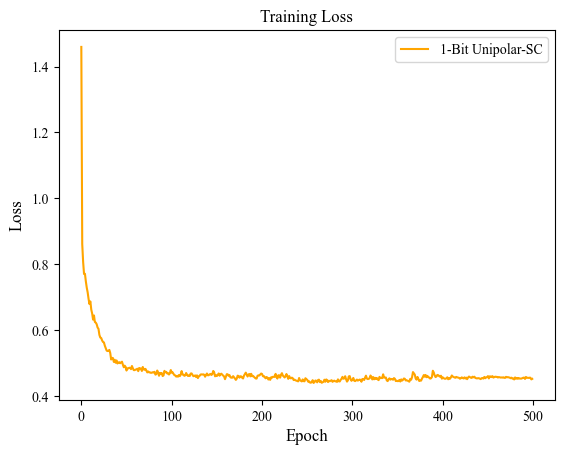

In [2501]:
font = {'family': 'Times New Roman',
        'size': '12'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_15_losses, color = 'orange', label = '1-Bit Unipolar-SC')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})
plt.savefig('1b_1v_U_loss.png') 
plt.show()

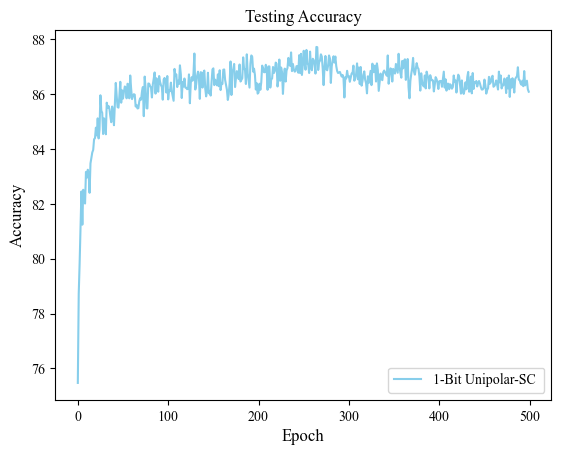

In [2502]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_15_acc, color = 'skyblue', label = '1-Bit Unipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('1b_1v_U_acc.png')  
plt.show()

In [1981]:
# testing
testModel = copy.deepcopy(model_2_15)

with torch.no_grad():
    numberCorrect = 0
    numberSamples = 0
    for i, (images, labels) in enumerate(testLoader): 
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        
        testSamples = torch.zeros(24, 1, 28, 28)
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        
        testSamples = torch.ge(images, referenceTrainData).float()
        
        images = testSamples.reshape(-1, 784)
        
        outputs = testModel(images, 0, 1, 1, 1, 1, 1, 1)
        
        # value and index of the correct predictions
        _, predictions = torch.max(outputs, 1)
        
        numberSamples += labels.shape[0]
        
        numberCorrect += (predictions == labels).sum().item()
        
        if i == 415:
            break
        
    accuracy = 100.0 * (numberCorrect) / numberSamples
    
    print(f'accuracy = {accuracy}')

accuracy = 84.44511217948718


In [2076]:
# MODEL _ 2 _ 16
# bipolar
# bitwidth = 1
# Voting Mechansim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, d_1, d_2, d_3, d_4):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = (2 * torch.rand(self.hiddenLayersSize, self.inputSize) / d_1) - 1
                referenceWeights_2 = (2 * torch.rand(self.numberClasses, self.hiddenLayersSize) / d_2) - 1
                referenceBias_1 = (2 * torch.rand(self.hiddenLayersSize) / d_3) - 1
                referenceBias_2 = (2 * torch.rand(self.numberClasses) / d_4) - 1
                
                self.linear_1.weight.data = 2 * torch.ge(self.linear_1.weight.data, referenceWeights_1).float() - 1
                self.linear_2.weight.data = 2 * torch.ge(self.linear_2.weight.data, referenceWeights_2).float() - 1
                self.linear_1.bias.data = 2 * torch.ge(self.linear_1.bias.data, referenceBias_1).float() - 1
                self.linear_2.bias.data = 2 * torch.ge(self.linear_2.bias.data, referenceBias_2).float() - 1

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = -1.0
        output = self.linear_2(output)
        return output
    
model_2_16 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_16_losses = []
model_2_16_acc = []

In [2464]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_16.parameters(), lr =  7e-8)

# training loop
n_total_steps = len(trainLoader)

for epoch in range(20):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.gt(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_16(samples, 0, 0, 1, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.01:
            print(f'{loss.item():.5f}')
            
        if loss.item() < 0.00003:
            print(f'{loss.item():.6f}')
        
        if (i+1) % 2500 == 0:
            model_2_16_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{20}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20

            samples = 2 * torch.ge(images, referenceTrainData).float() - 1

            images = samples.reshape(-1, 784)

            outputs = model_2_16(images, 0, 1, 1, 1, 1, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_16_acc.append(accuracy)

epoch 1/20, step 2500 / 2500, loss = 0.31534
accuracy = 86.14783653846153
epoch 2/20, step 2500 / 2500, loss = 0.31708
accuracy = 85.68709935897436
epoch 3/20, step 2500 / 2500, loss = 0.31488
accuracy = 85.77724358974359
epoch 4/20, step 2500 / 2500, loss = 0.31763
accuracy = 85.77724358974359
epoch 5/20, step 2500 / 2500, loss = 0.31844
accuracy = 85.99759615384616
epoch 6/20, step 2500 / 2500, loss = 0.31615
accuracy = 86.02764423076923
epoch 7/20, step 2500 / 2500, loss = 0.31664
accuracy = 85.47676282051282
0.00771
epoch 8/20, step 2500 / 2500, loss = 0.32023
accuracy = 85.5869391025641
epoch 9/20, step 2500 / 2500, loss = 0.31737
accuracy = 85.91746794871794
epoch 10/20, step 2500 / 2500, loss = 0.31662
accuracy = 85.51682692307692
epoch 11/20, step 2500 / 2500, loss = 0.31819
accuracy = 85.61698717948718
epoch 12/20, step 2500 / 2500, loss = 0.31795
accuracy = 85.41666666666667
epoch 13/20, step 2500 / 2500, loss = 0.31888
accuracy = 85.41666666666667
epoch 14/20, step 2500 / 25

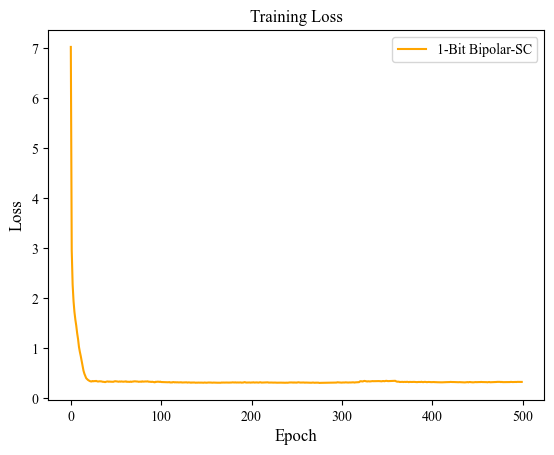

In [2506]:
font = {'family': 'Times New Roman',
        'size': '12'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_16_losses, color = 'orange', label = '1-Bit Bipolar-SC')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})
plt.savefig('1b_1v_B_loss.png') 
plt.show()

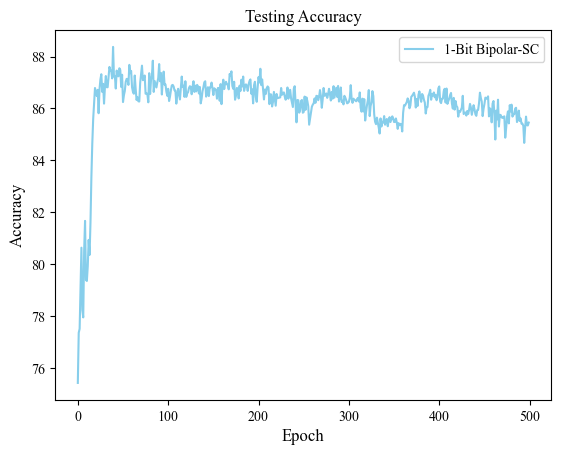

In [2504]:
font = {'family': 'Times New Roman',
        'size': '12'}
#temp = model_2_15_losses
plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_16_acc, color = 'skyblue', label = '1-Bit Bipolar-SC')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})
plt.savefig('1b_1v_B_acc.png') 
plt.show()

In [2144]:
# MODEL _ 2 _ 17
# bipolar
# bitwidth = 1
# Voting Mechansim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation_1 = nn.LeakyReLU()
        self.norm_1 = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, hiddenLayersSize, bias = True)
        self.activation_2 = nn.LeakyReLU()
        self.norm_2 = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_3 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting):
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = (2 * torch.rand(self.hiddenLayersSize, self.inputSize)) - 1
                referenceWeights_2 = (2 * torch.rand(self.hiddenLayersSize, self.hiddenLayersSize)) - 1
                referenceWeights_3 = (2 * torch.rand(self.numberClasses, self.hiddenLayersSize)) - 1
                referenceBias_1 = (2 * torch.rand(self.hiddenLayersSize)) - 1
                referenceBias_2 = (2 * torch.rand(self.hiddenLayersSize)) - 1
                referenceBias_3 = (2 * torch.rand(self.numberClasses)) - 1
                
                self.linear_1.weight.data = 2 * torch.ge(self.linear_1.weight.data, referenceWeights_1).float() - 1
                self.linear_2.weight.data = 2 * torch.ge(self.linear_2.weight.data, referenceWeights_2).float() - 1
                self.linear_3.weight.data = 2 * torch.ge(self.linear_3.weight.data, referenceWeights_3).float() - 1
                self.linear_1.bias.data = 2 * torch.ge(self.linear_1.bias.data, referenceBias_1).float() - 1
                self.linear_2.bias.data = 2 * torch.ge(self.linear_2.bias.data, referenceBias_2).float() - 1
                self.linear_3.bias.data = 2 * torch.ge(self.linear_3.bias.data, referenceBias_3).float() - 1

        output = self.linear_1(x)
        output = self.activation_1(output)
        output = self.norm_1(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = -1.0
        output = self.linear_2(output)
        output = self.activation_2(output)
        output = self.norm_2(output)
        output = self.linear_3(output)
        return output
    
model_2_17 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_17_losses = []
model_2_17_acc = []

In [2150]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_17.parameters(), lr =  7e-5)

# training loop
n_total_steps = len(trainLoader)

for epoch in range(50):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = 2 * torch.ge(images, referenceTrainData).float() - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_17(samples, 0, 0, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.1:
            print(f'{loss.item():.5f}')
            
        if loss.item() < 0.00003:
            print(f'{loss.item():.6f}')
        
        if (i+1) % 2500 == 0:
            model_2_17_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{50}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20

            samples = 2 * torch.ge(images, referenceTrainData).float() - 1

            images = samples.reshape(-1, 784)

            outputs = model_2_17(images, 0, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_17_acc.append(accuracy)

epoch 1/50, step 2500 / 2500, loss = 0.30127
accuracy = 90.234375
epoch 2/50, step 2500 / 2500, loss = 0.29566
accuracy = 90.53485576923077
epoch 3/50, step 2500 / 2500, loss = 0.29258
accuracy = 90.61498397435898
epoch 4/50, step 2500 / 2500, loss = 0.29137
accuracy = 90.8954326923077
epoch 5/50, step 2500 / 2500, loss = 0.29147
accuracy = 90.625
epoch 6/50, step 2500 / 2500, loss = 0.29187
accuracy = 90.43469551282051
epoch 7/50, step 2500 / 2500, loss = 0.29112
accuracy = 90.76522435897436
epoch 8/50, step 2500 / 2500, loss = 0.28892
accuracy = 90.9755608974359
epoch 9/50, step 2500 / 2500, loss = 0.28641
accuracy = 90.3545673076923
epoch 10/50, step 2500 / 2500, loss = 0.28915
accuracy = 90.99559294871794
epoch 11/50, step 2500 / 2500, loss = 0.28975
accuracy = 90.79527243589743
epoch 12/50, step 2500 / 2500, loss = 0.28374
accuracy = 90.13421474358974
epoch 13/50, step 2500 / 2500, loss = 0.29046
accuracy = 90.79527243589743
epoch 14/50, step 2500 / 2500, loss = 0.29383
accuracy =

In [2623]:
# MODEL _ 2 _ 18
# bipolar
# bitwidth = 1
# Voting Mechansim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, d_1, d_2, d_3, d_4):
        
        count_1 = torch.zeros(1000, 784)
        count_2 = torch.zeros(10, 1000)
        count_3 = torch.zeros(1000)
        count_4 = torch.zeros(10)
        
        if skipFlag == 0:                      
            for k in range(numberOfVoting):
                referenceWeights_1 = (2 * torch.rand(self.hiddenLayersSize, self.inputSize) / d_1) - 1
                referenceWeights_2 = (2 * torch.rand(self.numberClasses, self.hiddenLayersSize) / d_2) - 1
                referenceBias_1 = (2 * torch.rand(self.hiddenLayersSize) / d_3) - 1
                referenceBias_2 = (2 * torch.rand(self.numberClasses) / d_4) - 1
                
                self.linear_1.weight.data = 2 * torch.ge(self.linear_1.weight.data, referenceWeights_1).float() - 1
                self.linear_2.weight.data = 2 * torch.ge(self.linear_2.weight.data, referenceWeights_2).float() - 1
                self.linear_1.bias.data = 2 * torch.ge(self.linear_1.bias.data, referenceBias_1).float() - 1
                self.linear_2.bias.data = 2 * torch.ge(self.linear_2.bias.data, referenceBias_2).float() - 1

        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = -1.0
        output = self.linear_2(output)
        return output
    
model_2_18 = NeuralNetwork(inputSize, 1000, numberClasses)
model_2_18_losses = []
model_2_18_acc = []

In [2629]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_18.parameters(), lr =  7e-5)

# training loop
n_total_steps = len(trainLoader)

for epoch in range(10):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = 2 * torch.gt(images, referenceTrainData).float() - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_18(samples, 0, 0, 1, 1, 1, 1, 1)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < 0.01:
            print(f'{loss.item():.5f}')
            
        if loss.item() < 0.00003:
            print(f'{loss.item():.6f}')
        
        if (i+1) % 2500 == 0:
            model_2_18_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{10}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20

            samples = 2 * torch.ge(images, referenceTrainData).float() - 1

            images = samples.reshape(-1, 784)

            outputs = model_2_18(images, 0, 1, 1, 1, 1, 1, 1)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_18_acc.append(accuracy)

epoch 1/10, step 2500 / 2500, loss = 0.29633
accuracy = 90.72516025641026
epoch 2/10, step 2500 / 2500, loss = 0.28598
accuracy = 90.71514423076923
epoch 3/10, step 2500 / 2500, loss = 0.28374
accuracy = 91.17588141025641
epoch 4/10, step 2500 / 2500, loss = 0.28347
accuracy = 91.41626602564102
epoch 5/10, step 2500 / 2500, loss = 0.27983
accuracy = 91.17588141025641
epoch 6/10, step 2500 / 2500, loss = 0.27830
accuracy = 91.23597756410257
0.00963
epoch 7/10, step 2500 / 2500, loss = 0.27662
accuracy = 91.0556891025641
epoch 8/10, step 2500 / 2500, loss = 0.28022
accuracy = 91.35616987179488
epoch 9/10, step 2500 / 2500, loss = 0.28055
accuracy = 91.17588141025641
epoch 10/10, step 2500 / 2500, loss = 0.27893
accuracy = 91.22596153846153


In [2634]:
len(model_2_18_losses)

110

In [2630]:
# MODEL _ 3 _ Conventional

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.relu_1 = nn.LeakyReLU()
        self.norm_1 = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
    def forward(self, x):
        output = self.linear_1(x)
        output = self.relu_1(output)
        output = self.norm_1(output)
        output = self.linear_2(output)
        return output
    
model_3_Conventional = NeuralNetwork(inputSize, 1000, numberClasses)
model_3_Conventional_losses = []
model_3_Conventional_acc = []

In [2633]:
# loss
trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_3_Conventional.parameters(), lr = 7e-8)

# training loop
n_total_steps = len(trainLoader)

for epoch in range(30):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):        
                
        images = images.reshape(-1, 784)
                
        # forward
        outputs = model_3_Conventional(images)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2500 == 0:
            model_3_Conventional_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{30}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for images, labels in testLoader:  

            images = images.reshape(-1, 784)

            outputs = model_3_Conventional(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_3_Conventional_acc.append(accuracy)

epoch 1/30, step 2500 / 2500, loss = 0.0018
accuracy = 98.06
epoch 2/30, step 2500 / 2500, loss = 0.0023
accuracy = 98.21
epoch 3/30, step 2500 / 2500, loss = 0.0021
accuracy = 98.07
epoch 4/30, step 2500 / 2500, loss = 0.0018
accuracy = 97.88
epoch 5/30, step 2500 / 2500, loss = 0.0020
accuracy = 98.11
epoch 6/30, step 2500 / 2500, loss = 0.0021
accuracy = 98.13
epoch 7/30, step 2500 / 2500, loss = 0.0021
accuracy = 98.16
epoch 8/30, step 2500 / 2500, loss = 0.0015
accuracy = 98.03
epoch 9/30, step 2500 / 2500, loss = 0.0017
accuracy = 97.99
epoch 10/30, step 2500 / 2500, loss = 0.0024
accuracy = 98.08
epoch 11/30, step 2500 / 2500, loss = 0.0019
accuracy = 98.02
epoch 12/30, step 2500 / 2500, loss = 0.0014
accuracy = 98.12
epoch 13/30, step 2500 / 2500, loss = 0.0018
accuracy = 97.99
epoch 14/30, step 2500 / 2500, loss = 0.0018
accuracy = 97.9
epoch 15/30, step 2500 / 2500, loss = 0.0022
accuracy = 98.09
epoch 16/30, step 2500 / 2500, loss = 0.0021
accuracy = 98.07
epoch 17/30, step 

In [28]:
# MODEL _ 2 _ 19
# Biipolar
# bitwidth = 4
# Voting Mechansim = 4

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.activation = nn.LeakyReLU()
        self.norm = nn.BatchNorm1d(hiddenLayersSize)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberVoting, stochasticPrecision, threshhold):
        
        count_1 = torch.zeros(500, 784)
        count_2 = torch.zeros(10, 500)
        count_3 = torch.zeros(500)
        count_4 = torch.zeros(10)
        count_1_1 = torch.zeros(500, 784)
        count_2_1 = torch.zeros(10, 500)
        count_3_1 = torch.zeros(500)
        count_4_1 = torch.zeros(10)
        
        if skipFlag == 0:
            for q in range(stochasticPrecision):
                for k in range(numberVoting):
                    referenceWeights_1 = (2 * torch.rand(self.hiddenLayersSize, self.inputSize)) - 1
                    referenceWeights_2 = (2 * torch.rand(self.numberClasses, self.hiddenLayersSize))- 1
                    referenceBias_1 = (2 * torch.rand(self.hiddenLayersSize)) - 1
                    referenceBias_2 = (2 * torch.rand(self.numberClasses)) - 1

                    count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                    count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                    count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                    count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

                count_1_1 = torch.ge(count_1, threshhold).float()
                count_2_1 = torch.ge(count_2, threshhold).float()
                count_3_1 = torch.ge(count_3, threshhold).float()
                count_4_1 = torch.ge(count_4, threshhold).float()
                
            self.linear_1.weight.data = (2 * torch.div(count_1_1, stochasticPrecision)) - 1
            self.linear_2.weight.data = (2 * torch.div(count_2_1, stochasticPrecision)) - 1
            self.linear_1.bias.data = (2 * torch.div(count_3_1, stochasticPrecision)) - 1
            self.linear_2.bias.data = (2 * torch.div(count_4_1, stochasticPrecision)) - 1
        
        output = self.linear_1(x)
        output = self.activation(output)
        output = self.norm(output)
        if flag == 1:
            randomVariables = torch.randn(24, 500)
            for i in range(len(output)):
                for j in range(500):
                    if output[i][j] >= randomVariables[i][j]:
                        output[i][j]= 1.0
                    else:
                        output[i][j] = -1.0
        output = self.linear_2(output)
        return output
    
model_2_19 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_19_losses = []
model_2_19_acc = []

In [29]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_19.parameters(), lr =  7e-4)

# training loop
n_total_steps = len(trainLoader)

flag = 0

for epoch in range(10):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = (2 * torch.ge(images, referenceTrainData).float()) - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_19(samples, 0, 0, 4, 4, 2)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if loss.item() < 0.0003:
            print(f'{loss.item():.6f}')

        
        if (i+1) % 2500 == 0:
            model_2_19_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{10}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.5f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader): 

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20

            samples = 2 * torch.ge(images, referenceTrainData).float() - 1

            images = samples.reshape(-1, 784)

            outputs = model_2_19(images, 0, 1, 4, 4, 2)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_19_acc.append(accuracy)

epoch 1/10, step 2500 / 2500, loss = 2.36234
accuracy = 17.708333333333332
epoch 2/10, step 2500 / 2500, loss = 2.29434
accuracy = 19.81169871794872
epoch 3/10, step 2500 / 2500, loss = 2.29426
accuracy = 19.801682692307693
epoch 4/10, step 2500 / 2500, loss = 2.29664
accuracy = 18.279246794871796
epoch 5/10, step 2500 / 2500, loss = 2.29554
accuracy = 17.64823717948718
epoch 6/10, step 2500 / 2500, loss = 2.29402
accuracy = 18.609775641025642
epoch 7/10, step 2500 / 2500, loss = 2.29823
accuracy = 19.971955128205128
epoch 8/10, step 2500 / 2500, loss = 2.29263
accuracy = 18.118990384615383
epoch 9/10, step 2500 / 2500, loss = 2.29642
accuracy = 20.352564102564102
epoch 10/10, step 2500 / 2500, loss = 2.29327
accuracy = 19.501201923076923


In [54]:
from torch.autograd import Function

class STEFunctionWeight(Function):
    @staticmethod
    def forward(ctx, input, numberOfVoting, hiddenLayersSize, inputSize):
        # Forward pass : Apply stochastic encoding to the layer parameters
        threshhold = numberOfVoting / 2
        count = torch.zeros(hiddenLayersSize, inputSize)
        for k in range(numberOfVoting):
            referenceParam = torch.rand(hiddenLayersSize, inputSize)
            count = torch.add( torch.ge(input, referenceParam).float(), count)
        output = torch.ge(count, threshhold).float()
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass: Pass through the gradient without any modification
        return grad_output

In [55]:
from torch.autograd import Function

class STEFunctionBias(Function):
    @staticmethod
    def forward(ctx, input, numberOfVoting, LayersSize):
        # Forward pass : Apply stochastic encoding to the layer parameters
        threshhold = numberOfVoting / 2
        count = torch.zeros(LayersSize)
        for k in range(numberOfVoting):
            referenceParam = torch.rand(LayersSize)
            count = torch.add( torch.ge(input, referenceParam).float(), count)
        output = torch.ge(count, threshhold).float()
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass: Pass through the gradient without any modification
        return grad_output

In [56]:
# MODEL _ 2 _ 20
# Unipolar
# bitwidth = 1
# Voting Mechansim = 4

numberOfVoting = 4
threshhold = numberOfVoting / 2

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(inputSize, hiddenLayersSize, bias = True)
        self.linear_2 = nn.Linear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x, flag, skipFlag, numberOfVoting, threshhold):
        
        #count_1 = torch.zeros(500, 784)
        #count_2 = torch.zeros(10, 500)
        #count_3 = torch.zeros(500)
        #count_4 = torch.zeros(10)
        
        if skipFlag == 0:
            self.linear_1.weight.data = STEFunctionWeight.apply(self.linear_1.weight.data, numberOfVoting, self.hiddenLayersSize, self.inputSize)
            self.linear_2.weight.data = STEFunctionWeight.apply(self.linear_2.weight.data, numberOfVoting, self.numberClasses, self.hiddenLayersSize)
            self.linear_1.bias.data = STEFunctionBias.apply(self.linear_1.bias.data, numberOfVoting, self.hiddenLayersSize)
            self.linear_2.bias.data = STEFunctionBias.apply(self.linear_2.bias.data, numberOfVoting, self.numberClasses)
            """
            #with torch.no_grad():               
            for k in range(numberOfVoting):
                referenceWeights_1 = torch.rand(self.hiddenLayersSize, self.inputSize)
                referenceWeights_2 = torch.rand(self.numberClasses, self.hiddenLayersSize)
                referenceBias_1 = torch.rand(self.hiddenLayersSize)
                referenceBias_2 = torch.rand(self.numberClasses)
                count_1 = torch.add( torch.ge(self.linear_1.weight.data, referenceWeights_1).float(), count_1)
                count_2 = torch.add( torch.ge(self.linear_2.weight.data, referenceWeights_2).float(), count_2)
                count_3 = torch.add( torch.ge(self.linear_1.bias.data, referenceBias_1).float(), count_3)
                count_4 = torch.add( torch.ge(self.linear_2.bias.data, referenceBias_2).float(), count_4)

            self.linear_1.weight.data = torch.ge(count_1, threshhold).float()
            self.linear_2.weight.data = torch.ge(count_2, threshhold).float()
            self.linear_1.bias.data = torch.ge(count_3, threshhold).float()
            self.linear_2.bias.data = torch.ge(count_4, threshhold).float()

            count_1 = torch.zeros(500, 784)
            count_2 = torch.zeros(10, 500)
            count_3 = torch.zeros(500)
            count_4 = torch.zeros(10)"""

        output = self.linear_1(x)
        output = torch.clamp(output, 0, 1)
        output = self.linear_2(output)
        return output
    
model_2_20 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_20_losses = []
model_2_20_acc = []

In [70]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_20.parameters(), lr = 7e-3)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(5):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_20(samples, 0, skipFlag, 4, 2)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (loss.item() < 0.0003) or (loss.item() < 0.01):
            print(f'{loss.item():.4f}')
            
        if (i+1) % 2500 == 0:
            model_2_20_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{5}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            dataCount = torch.zeros(24, 1, 28, 28)

            for k in range(numberOfVoting):
                referenceTrainData = torch.rand(24, 1, 28, 28)/20
                dataCount = torch.add( torch.gt(images, referenceTrainData).float(), dataCount)

            samples = torch.div(dataCount, numberOfVoting)

            images = samples.reshape(-1, 784)

            outputs = model_2_20(images, 0, 1, 4, 2)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_20_acc.append(accuracy)

epoch 1/5, step 2500 / 2500, loss = 1.3499
accuracy = 69.21073717948718
epoch 2/5, step 2500 / 2500, loss = 1.3141
accuracy = 62.610176282051285
epoch 3/5, step 2500 / 2500, loss = 1.2985
accuracy = 63.40144230769231
epoch 4/5, step 2500 / 2500, loss = 1.3316
accuracy = 72.15544871794872
epoch 5/5, step 2500 / 2500, loss = 1.3409
accuracy = 66.19591346153847


In [172]:
class LinearFunction(Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        # The forward pass can use ctx.
        ctx.save_for_backward(input, weight, bias)
        count = torch.zeros_like(weight)
        for k in range(4):
            referenceParam = torch.rand_like(weight)
            #referenceParam = nn.init.uniform_(weight, torch.min(weight), torch.max(weight))
            count = torch.add( torch.ge(weight, referenceParam).float(), count)
        tempWeight = torch.ge(count, 2).float()
        #print(referenceParam[0][0:20])
        output = input.mm(tempWeight.t())
        if bias is not None:
            count = torch.zeros_like(bias)
            for k in range(4):
                referenceParam = torch.rand_like(bias)
                #referenceParam = nn.init.uniform_(bias, torch.min(bias), torch.max(bias))
                count = torch.add( torch.ge(bias, referenceParam).float(), count)
            tempBias = torch.ge(count, 2).float()
            output += tempBias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

In [173]:
class CustomLinear(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here
        return LinearFunction.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [174]:
# MODEL _ 2 _ 21
# Unipolar
# bitwidth = 1
# Voting Mechansim = 4

numberOfVoting = 4
threshhold = numberOfVoting / 2

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = CustomLinear(inputSize, hiddenLayersSize, bias = True)
        self.linear_2 = CustomLinear(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x):

        output = self.linear_1(x)
        output = torch.clamp(output, 0, 1)
        output = self.linear_2(output)
        return output
    
model_2_21 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_21_losses = []
model_2_21_acc = []

In [200]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_21.parameters(), lr = 7e-6)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(50):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_21(samples)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if (loss.item() < 0.0003) or (loss.item() < 0.01):
            #print(f'{loss.item():.4f}')
            
        if (i+1) % 2500 == 0:
            model_2_21_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{50}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            
            samples = torch.ge(images, referenceTrainData).float()

            images = samples.reshape(-1, 784)

            outputs = model_2_21(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_21_acc.append(accuracy)

epoch 1/50, step 2500 / 2500, loss = 0.3108
accuracy = 92.8886217948718
epoch 2/50, step 2500 / 2500, loss = 0.3172
accuracy = 92.99879807692308
epoch 3/50, step 2500 / 2500, loss = 0.3051
accuracy = 93.51963141025641
epoch 4/50, step 2500 / 2500, loss = 0.3087
accuracy = 92.78846153846153
epoch 5/50, step 2500 / 2500, loss = 0.3020
accuracy = 92.8886217948718
epoch 6/50, step 2500 / 2500, loss = 0.3097
accuracy = 92.6181891025641
epoch 7/50, step 2500 / 2500, loss = 0.3087
accuracy = 92.76842948717949
epoch 8/50, step 2500 / 2500, loss = 0.3111
accuracy = 93.0088141025641
epoch 9/50, step 2500 / 2500, loss = 0.3069
accuracy = 93.25921474358974
epoch 10/50, step 2500 / 2500, loss = 0.3188
accuracy = 92.5380608974359
epoch 11/50, step 2500 / 2500, loss = 0.3110
accuracy = 93.22916666666667
epoch 12/50, step 2500 / 2500, loss = 0.3173
accuracy = 93.24919871794872
epoch 13/50, step 2500 / 2500, loss = 0.3082
accuracy = 93.19911858974359
epoch 14/50, step 2500 / 2500, loss = 0.3079
accurac

In [255]:
class LinearFunction_1(Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        # The forward pass can use ctx.
        ctx.save_for_backward(input, weight, bias)
        count = torch.zeros_like(weight)
        for k in range(4):
            referenceParam = torch.rand_like(weight)
            #referenceParam = nn.init.uniform_(weight, torch.min(weight), torch.max(weight))
            count = torch.add( torch.ge(weight, referenceParam).float(), count)
        tempWeight = torch.ge(count, 2).float()
        #print(referenceParam[0][0:20])
        output = input.mm(tempWeight.t())
        if bias is not None:
            count = torch.zeros_like(bias)
            for k in range(4):
                referenceParam = torch.rand_like(bias)
                #referenceParam = nn.init.uniform_(bias, torch.min(bias), torch.max(bias))
                count = torch.add( torch.ge(bias, referenceParam).float(), count)
            tempBias = torch.ge(count, 2).float()
            output += tempBias.unsqueeze(0).expand_as(output)
        #print(output[0][0:10])
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        
        #print(grad_output[0])
        grad_output = F.hardtanh(grad_output)
        """count = torch.zeros_like(grad_output)
        for k in range(4):
            referenceParam = torch.rand_like(grad_output)
            #referenceParam = nn.init.uniform_(grad_output, torch.min(grad_output), torch.max(grad_output))
            count = torch.add( torch.ge(grad_output, referenceParam).float(), count)
        grad_output = torch.ge(count, 2).float()"""
        
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
            
        return grad_input, grad_weight, grad_bias

In [256]:
class CustomLinear_1(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here
        return LinearFunction_1.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [257]:
# MODEL _ 2 _ 22
# Unipolar
# bitwidth = 1
# Voting Mechansim = 4

numberOfVoting = 4
threshhold = numberOfVoting / 2

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = CustomLinear_1(inputSize, hiddenLayersSize, bias = True)
        self.linear_2 = CustomLinear_1(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x):

        output = self.linear_1(x)
        output = torch.clamp(output, 0, 1)
        output = self.linear_2(output)
        return output
    
model_2_22 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_22_losses = []
model_2_22_acc = []

In [273]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_22.parameters(), lr = 7e-4)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(100):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_22(samples)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if (loss.item() < 0.0003) or (loss.item() < 0.01):
            #print(f'{loss.item():.4f}')
            
        if (i+1) % 2500 == 0:
            model_2_22_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{100}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            
            samples = torch.ge(images, referenceTrainData).float()

            images = samples.reshape(-1, 784)

            outputs = model_2_22(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_22_acc.append(accuracy)

epoch 1/100, step 2500 / 2500, loss = 0.3430
accuracy = 92.9286858974359
epoch 2/100, step 2500 / 2500, loss = 0.3231
accuracy = 92.89863782051282
epoch 3/100, step 2500 / 2500, loss = 0.3408
accuracy = 93.05889423076923
epoch 4/100, step 2500 / 2500, loss = 0.3348
accuracy = 92.6582532051282
epoch 5/100, step 2500 / 2500, loss = 0.3386
accuracy = 92.90865384615384
epoch 6/100, step 2500 / 2500, loss = 0.3332
accuracy = 92.89863782051282
epoch 7/100, step 2500 / 2500, loss = 0.3446
accuracy = 92.81850961538461
epoch 8/100, step 2500 / 2500, loss = 0.3382
accuracy = 93.37940705128206
epoch 9/100, step 2500 / 2500, loss = 0.3337
accuracy = 92.85857371794872
epoch 10/100, step 2500 / 2500, loss = 0.3285
accuracy = 92.8886217948718
epoch 11/100, step 2500 / 2500, loss = 0.3258
accuracy = 92.95873397435898
epoch 12/100, step 2500 / 2500, loss = 0.3424
accuracy = 93.02884615384616
epoch 13/100, step 2500 / 2500, loss = 0.3283
accuracy = 92.4579326923077
epoch 14/100, step 2500 / 2500, loss =

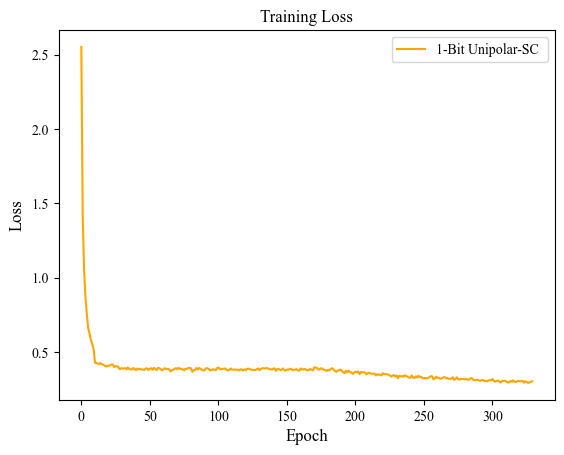

In [274]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_22_losses, color = 'orange', label = '1-Bit Unipolar-SC ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.title('Training Loss', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('1b_1v_U_loss_new.png') 
plt.show()

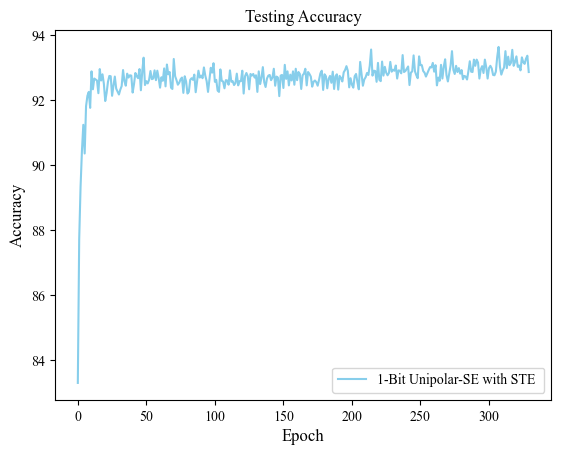

In [300]:
font = {'family': 'Times New Roman',
        'size': '12'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_22_acc, color = 'skyblue', label = '1-Bit Unipolar-SE with STE ')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman',
                 'size' : 10})

plt.savefig('1b_1v_U_acc_STE.png')  
plt.show()

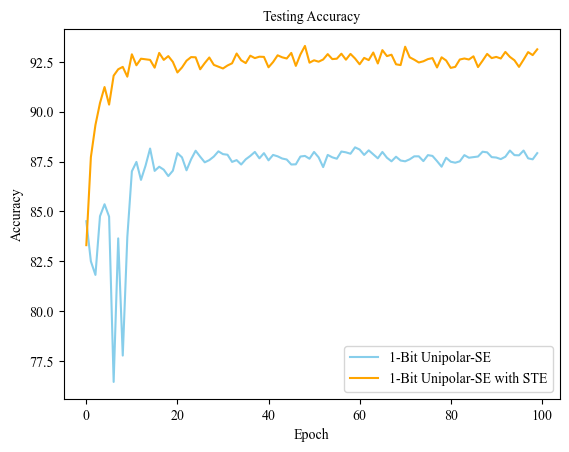

In [308]:
font = {'family': 'Times New Roman', 'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(model_2_15_acc[0:100], color = 'skyblue', label = '1-Bit Unipolar-SE')
plt.plot(model_2_22_acc[0:100], color = 'orange', label = '1-Bit Unipolar-SE with STE')

plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.title('Testing Accuracy', fontdict=font)

plt.legend(prop={'family': 'Times New Roman', 'size' : 10})

plt.savefig('Unipolar_Acc_Comparison_new_7.12.2023.png')  
plt.show()

In [276]:
class LinearFunction_2(Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        # The forward pass can use ctx.
        ctx.save_for_backward(input, weight, bias)
        count = torch.zeros_like(weight)
        for k in range(4):
            referenceParam = (2 * torch.rand_like(weight)) - 1
            #referenceParam = nn.init.uniform_(weight, torch.min(weight), torch.max(weight))
            count = torch.add( torch.ge(weight, referenceParam).float(), count)
        tempWeight = (2 * torch.ge(count, 2).float()) - 1
        #print(referenceParam[0][0:20])
        output = input.mm(tempWeight.t())
        if bias is not None:
            count = torch.zeros_like(bias)
            for k in range(4):
                referenceParam = (2 * torch.rand_like(bias)) - 1
                #referenceParam = nn.init.uniform_(bias, torch.min(bias), torch.max(bias))
                count = torch.add( torch.ge(bias, referenceParam).float(), count)
            tempBias = (2 * torch.ge(count, 2).float()) - 1
            output += tempBias.unsqueeze(0).expand_as(output)
        #print(output[0][0:10])
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        
        #print(grad_output[0])
        grad_output = F.hardtanh(grad_output)
        """count = torch.zeros_like(grad_output)
        for k in range(4):
            referenceParam = torch.rand_like(grad_output)
            #referenceParam = nn.init.uniform_(grad_output, torch.min(grad_output), torch.max(grad_output))
            count = torch.add( torch.ge(grad_output, referenceParam).float(), count)
        grad_output = torch.ge(count, 2).float()"""
        
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
            
        return grad_input, grad_weight, grad_bias

In [277]:
class CustomLinear_2(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here
        return LinearFunction_2.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [289]:
# MODEL _ 2 _ 23
# Bipolar
# bitwidth = 1
# Voting Mechansim = 4

numberOfVoting = 4
threshhold = numberOfVoting / 2

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = CustomLinear_2(inputSize, hiddenLayersSize, bias = True)
        self.linear_2 = CustomLinear_2(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x):

        output = self.linear_1(x)
        output = torch.clamp(output, -1, 1)
        output = self.linear_2(output)
        return output
    
model_2_23 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_23_losses = []
model_2_23_acc = []

In [295]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_23.parameters(), lr = 7e-4)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(50):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = (2 * torch.ge(images, referenceTrainData).float()) - 1
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_23(samples)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if (loss.item() < 0.0003) or (loss.item() < 0.01):
            #print(f'{loss.item():.4f}')
            
        if (i+1) % 2500 == 0:
            model_2_23_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{50}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            
            samples = (2 * torch.ge(images, referenceTrainData).float()) - 1

            images = samples.reshape(-1, 784)

            outputs = model_2_23(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_23_acc.append(accuracy)

epoch 1/50, step 2500 / 2500, loss = 3.4823
accuracy = 80.04807692307692
epoch 2/50, step 2500 / 2500, loss = 3.5386
accuracy = 80.17828525641026
epoch 3/50, step 2500 / 2500, loss = 3.5287
accuracy = 80.59895833333333
epoch 4/50, step 2500 / 2500, loss = 3.4848
accuracy = 79.47716346153847
epoch 5/50, step 2500 / 2500, loss = 3.5137
accuracy = 80.51883012820512
epoch 6/50, step 2500 / 2500, loss = 3.4736
accuracy = 80.80929487179488
epoch 7/50, step 2500 / 2500, loss = 3.4851
accuracy = 80.28846153846153
epoch 8/50, step 2500 / 2500, loss = 3.4428
accuracy = 80.02804487179488
epoch 9/50, step 2500 / 2500, loss = 3.4740
accuracy = 80.66907051282051
epoch 10/50, step 2500 / 2500, loss = 3.4882
accuracy = 79.19671474358974
epoch 11/50, step 2500 / 2500, loss = 3.5120
accuracy = 79.46714743589743
epoch 12/50, step 2500 / 2500, loss = 3.4624
accuracy = 80.078125
epoch 13/50, step 2500 / 2500, loss = 3.5065
accuracy = 79.73758012820512
epoch 14/50, step 2500 / 2500, loss = 3.4517
accuracy =

In [189]:
class LinearFunction_3(torch.autograd.Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        # The forward pass can use ctx.
        #ctx.save_for_backward(input, weight, bias)
        count = torch.zeros_like(weight)
        for k in range(4):
            referenceParam = torch.rand_like(weight)
            count = torch.add( torch.ge(weight, referenceParam).float(), count)
        tempWeight = torch.ge(count, 2).float()
        output = input.mm(tempWeight.t())
        if bias is not None:
            count = torch.zeros_like(bias)
            for k in range(4):
                referenceParam = torch.rand_like(bias)
                count = torch.add( torch.ge(bias, referenceParam).float(), count)
            tempBias = torch.ge(count, 2).float()
            output += tempBias.unsqueeze(0).expand_as(output)
        ctx.save_for_backward(input, tempWeight, tempBias)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        
        grad_output = F.hardtanh(grad_output)
        """count = torch.zeros_like(grad_output)
        for k in range(4):
            referenceParam = torch.rand_like(grad_output)
            #referenceParam = nn.init.uniform_(grad_output, torch.min(grad_output), torch.max(grad_output))
            count = torch.add( torch.ge(grad_output, referenceParam).float(), count)
        grad_output = torch.ge(count, 2).float()"""
        
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
            
        return grad_input, grad_weight, grad_bias

In [190]:
class CustomLinear_3(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here
        return LinearFunction_3.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [166]:
class Step(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.clamp(input, 0, 1)
        #return torch.gt(input, 0).float()
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        #print((grad_output[0]))
        #print(torch.max(grad_output))
        #print(torch.min(grad_output))
        return F.hardtanh(grad_output)
        #return F.hardtanh(grad_output)
        #return torch.gt(grad_output, 0).float()
        #return grad_output
        #return torch.max(grad_output, torch.zeros_like(grad_output))

In [191]:
# MODEL _ 2 _ 24
# Unipolar
# bitwidth = 1
# Voting Mechansim = 4

numberOfVoting = 4
threshhold = numberOfVoting / 2

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = CustomLinear_3(inputSize, hiddenLayersSize, bias = True)
        self.linear_2 = CustomLinear_3(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x):
        output = self.linear_1(x)
        output = torch.clamp(output, 0, 1)
        output = self.linear_2(output)
        return output
    
model_2_24 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_24_losses = []
model_2_24_acc = []

In [208]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_24.parameters(), lr = 7e-3)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(300):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_24(samples)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if (i+1) % 2500 == 0:
            model_2_24_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{300}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            
            samples = torch.ge(images, referenceTrainData).float()

            images = samples.reshape(-1, 784)

            outputs = model_2_24(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_24_acc.append(accuracy)

epoch 1/300, step 2500 / 2500, loss = 0.2761
accuracy = 92.38782051282051
epoch 2/300, step 2500 / 2500, loss = 0.2682
accuracy = 92.48798076923077
epoch 3/300, step 2500 / 2500, loss = 0.2842
accuracy = 92.68830128205128
epoch 4/300, step 2500 / 2500, loss = 0.2714
accuracy = 92.40785256410257
epoch 5/300, step 2500 / 2500, loss = 0.2652
accuracy = 92.24759615384616
epoch 6/300, step 2500 / 2500, loss = 0.2801
accuracy = 92.37780448717949
epoch 7/300, step 2500 / 2500, loss = 0.2694
accuracy = 92.38782051282051
epoch 8/300, step 2500 / 2500, loss = 0.2806
accuracy = 92.48798076923077
epoch 9/300, step 2500 / 2500, loss = 0.2814
accuracy = 92.64823717948718
epoch 10/300, step 2500 / 2500, loss = 0.2743
accuracy = 92.63822115384616
epoch 11/300, step 2500 / 2500, loss = 0.2711
accuracy = 91.98717948717949
epoch 12/300, step 2500 / 2500, loss = 0.2685
accuracy = 91.51642628205128
epoch 13/300, step 2500 / 2500, loss = 0.2773
accuracy = 92.05729166666667
epoch 14/300, step 2500 / 2500, lo

In [269]:
x = torch.randn(10,10)
y = x * torch.sigmoid(0.5 * x)
z = F.hardtanh(x)

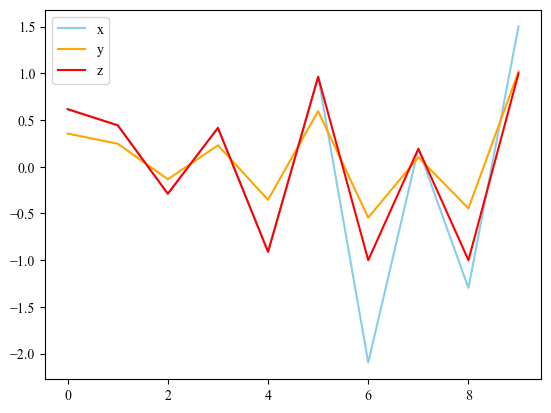

In [270]:
font = {'family': 'Times New Roman', 'size': '10'}

plt.xticks(fontname = 'Times New Roman', fontsize = 10)
plt.yticks(fontname = 'Times New Roman', fontsize = 10)

plt.plot(x[0], color = 'skyblue', label = 'x')
plt.plot(y[0], color = 'orange', label = 'y')
plt.plot(z[0], color = 'red', label = 'z')

plt.legend(prop={'family': 'Times New Roman', 'size' : 10})

plt.show()

In [317]:
# Using Swish function
class LinearFunction_4(torch.autograd.Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        # The forward pass can use ctx.
        #ctx.save_for_backward(input, weight, bias)
        count = torch.zeros_like(weight)
        for k in range(4):
            referenceParam = torch.rand_like(weight)
            #referenceParam = nn.init.uniform_(weight, torch.min(weight), torch.max(weight))
            count = torch.add( torch.ge(weight, referenceParam).float(), count)
        tempWeight = torch.ge(count, 2).float()
        #print(referenceParam[0][0:20])
        output = input.mm(tempWeight.t())
        if bias is not None:
            count = torch.zeros_like(bias)
            for k in range(4):
                referenceParam = torch.rand_like(bias)
                #referenceParam = nn.init.uniform_(bias, torch.min(bias), torch.max(bias))
                count = torch.add( torch.ge(bias, referenceParam).float(), count)
            tempBias = torch.ge(count, 2).float()
            output += tempBias.unsqueeze(0).expand_as(output)
        #print(output[0][0:10])
        #print(input[0])
        ctx.save_for_backward(input, tempWeight, tempBias)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        
        #print(grad_output[0])
        grad_output = F.hardtanh(grad_output)
        #grad_output = grad_output * F.sigmoid(0.3 * grad_output)
        """count = torch.zeros_like(grad_output)
        for k in range(4):
            referenceParam = torch.rand_like(grad_output)
            #referenceParam = nn.init.uniform_(grad_output, torch.min(grad_output), torch.max(grad_output))
            count = torch.add( torch.ge(grad_output, referenceParam).float(), count)
        grad_output = torch.ge(count, 2).float()"""
        
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
            
        return grad_input, grad_weight, grad_bias

In [318]:
class CustomLinear_4(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here
        return LinearFunction_4.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [313]:
# MODEL _ 2 _ 25
# Unipolar
# bitwidth = 1
# Voting Mechansim = 4
# Using Swish Function

numberOfVoting = 4
threshhold = numberOfVoting / 2

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = CustomLinear_4(inputSize, hiddenLayersSize, bias = True)
        self.linear_2 = CustomLinear_4(hiddenLayersSize, numberClasses, bias = True)
        #self.activation = Step.apply
        #self.activation = nn.Sigmoid()
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x):
        output = self.linear_1(x)
        output = torch.clamp(output, 0, 1)
        #output = self.activation(output)
        output = self.linear_2(output)
        return output
    
model_2_25 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_25_losses = []
model_2_25_acc = []

In [ ]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_25.parameters(), lr = 1e-3)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(20):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_25(samples)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if (i+1) % 2500 == 0:
            model_2_25_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{20}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            
            samples = torch.ge(images, referenceTrainData).float()

            images = samples.reshape(-1, 784)

            outputs = model_2_25(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_25_acc.append(accuracy)

In [348]:
class LinearFunction_5(torch.autograd.Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        # The forward pass can use ctx.
        #ctx.save_for_backward(input, weight, bias)
        count = torch.zeros_like(weight)
        for k in range(32):
            referenceParam = torch.rand_like(weight)
            count = torch.add( torch.ge(weight, referenceParam).float(), count)
        tempWeight = torch.div(count, 32)
        output = input.mm(tempWeight.t())
        if bias is not None:
            count = torch.zeros_like(bias)
            for k in range(32):
                referenceParam = torch.rand_like(bias)
                count = torch.add( torch.ge(bias, referenceParam).float(), count)
            tempBias = torch.div(count, 32)
            output += tempBias.unsqueeze(0).expand_as(output)
        ctx.save_for_backward(input, tempWeight, tempBias)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        
        grad_output = F.hardtanh(grad_output)
  
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
            
        return grad_input, grad_weight, grad_bias
    
class CustomLinear_5(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here
        return LinearFunction_5.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [355]:
# MODEL _ 2 _ 26
# Unipolar
# bitwidth = 4096
# Voting Mechansim = Off
# FC784-FC500-F10

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = CustomLinear_5(inputSize, hiddenLayersSize, bias = True)
        self.linear_2 = CustomLinear_5(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x):
        output = self.linear_1(x)
        output = torch.clamp(output, 0, 1)
        output = self.linear_2(output)
        return output
    
model_2_26 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_26_losses = []
model_2_26_acc = []

In [359]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_26.parameters(), lr = 1e-3)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(100):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        samples = torch.zeros_like(images)
        for k in range(32):
            referenceParam = torch.rand_like(images)
            samples = torch.add( torch.ge(images, referenceParam).float(), samples)
        samples = torch.div(samples, 32)
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_26(samples)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if (i+1) % 2500 == 0:
            model_2_26_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{100}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers           
            samples = torch.zeros_like(images)
            for k in range(32):
                referenceParam = torch.rand_like(images)
                samples = torch.add( torch.ge(images, referenceParam).float(), samples)
            samples = torch.div(samples, 32)

            images = samples.reshape(-1, 784)

            outputs = model_2_26(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_26_acc.append(accuracy)

epoch 1/100, step 2500 / 2500, loss = 0.0479
accuracy = 97.08533653846153
epoch 2/100, step 2500 / 2500, loss = 0.0451
accuracy = 97.11538461538461
epoch 3/100, step 2500 / 2500, loss = 0.0416
accuracy = 97.29567307692308
epoch 4/100, step 2500 / 2500, loss = 0.0411
accuracy = 97.35576923076923
epoch 5/100, step 2500 / 2500, loss = 0.0393
accuracy = 97.47596153846153
epoch 6/100, step 2500 / 2500, loss = 0.0379
accuracy = 97.1854967948718
epoch 7/100, step 2500 / 2500, loss = 0.0360
accuracy = 97.3858173076923
epoch 8/100, step 2500 / 2500, loss = 0.0349
accuracy = 97.45592948717949
epoch 9/100, step 2500 / 2500, loss = 0.0332
accuracy = 97.3858173076923
epoch 10/100, step 2500 / 2500, loss = 0.0323
accuracy = 97.3858173076923
epoch 11/100, step 2500 / 2500, loss = 0.0311
accuracy = 97.52604166666667
epoch 12/100, step 2500 / 2500, loss = 0.0289
accuracy = 97.49599358974359
epoch 13/100, step 2500 / 2500, loss = 0.0290
accuracy = 97.36578525641026
epoch 14/100, step 2500 / 2500, loss =

KeyboardInterrupt: 

In [468]:
# Adopting Binary bitwise MM using AND gate
class LinearFunction_6(torch.autograd.Function):
    @staticmethod
    # ctx is the first argument to forward
    def forward(ctx, input, weight, bias=None):
        # The forward pass can use ctx.
        #ctx.save_for_backward(input, weight, bias)
        print(weight[0])
        count = torch.zeros_like(weight)
        for k in range(4):
            referenceParam = torch.rand_like(weight)
            count = torch.add( torch.ge(weight, referenceParam).float(), count)
        tempWeight = torch.ge(count, 2).float()
        print(tempWeight[0])
        output = input.mm(tempWeight.t())
        print(output[0])
        print('bias:')
        print(bias)
        if bias is not None:
            count = torch.zeros_like(bias)
            for k in range(4):
                referenceParam = torch.rand_like(bias)
                count = torch.add( torch.ge(bias, referenceParam).float(), count)
            tempBias = torch.ge(count, 2).float()
            output += tempBias.unsqueeze(0).expand_as(output)
        print(tempBias)
        ctx.save_for_backward(input, tempWeight, tempBias)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        
        grad_output = F.hardtanh(grad_output)
          
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
            
        return grad_input, grad_weight, grad_bias
    
class CustomLinear_6(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here
        return LinearFunction_6.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [469]:
# MODEL _ 2 _ 27
# Unipolar
# bitwidth = 1
# Voting Mechansim = 4
# FC784-FC500-F10

class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, hiddenLayersSize, numberClasses):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = CustomLinear_6(inputSize, hiddenLayersSize, bias = True)
        self.linear_2 = CustomLinear_6(hiddenLayersSize, numberClasses, bias = True)
        
        self.inputSize = inputSize
        self.hiddenLayersSize = hiddenLayersSize
        self.numberClasses = numberClasses
        
    def forward(self, x):
        output = self.linear_1(x)
        output = torch.clamp(output, 0, 1)
        print(output[0])
        print('------------')
        output = self.linear_2(output)
        return output
    
model_2_27 = NeuralNetwork(inputSize, 500, numberClasses)
model_2_27_losses = []
model_2_27_acc = []

In [470]:
# loss

trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=24, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2_27.parameters(), lr = 1e-3)

# training loop
n_total_steps = len(trainLoader)

flag = 0
skipFlag = 0

for epoch in range(10):
    totalLoss = 0
    for i, (images, labels) in enumerate(trainLoader):
        
        # Change the input data format of the mnist dataset to stochastic form using reference random numbers
        referenceTrainData = torch.rand(24, 1, 28, 28)/20
        samples = torch.zeros(24, 1, 28, 28)
        
        samples = torch.ge(images, referenceTrainData).float()
                
        samples = samples.reshape(-1, 784)
             
        # forward
        outputs = model_2_27(samples)
        loss = criterion(outputs, labels)
        totalLoss += loss.item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if (i+1) % 2500 == 0:
            model_2_27_losses.append(totalLoss/2500)
            print(f'epoch {epoch+1}/{10}, step {i+1} / {n_total_steps}, loss = {totalLoss/2500:.4f}')
            
    with torch.no_grad():
        numberCorrect = 0
        numberSamples = 0
        for z, (images, labels) in enumerate(testLoader):  

            # Change the input data format of the mnist dataset to stochastic form using reference random numbers
            samples = torch.zeros(24, 1, 28, 28)
            referenceTrainData = torch.rand(24, 1, 28, 28)/20
            
            samples = torch.ge(images, referenceTrainData).float()

            images = samples.reshape(-1, 784)

            outputs = model_2_27(images)

            # value and index of the correct predictions
            _, predictions = torch.max(outputs, 1)

            numberSamples += labels.shape[0]

            numberCorrect += (predictions == labels).sum().item()

            if z == 415:
                break

        accuracy = 100.0 * (numberCorrect) / numberSamples

        print(f'accuracy = {accuracy}')
        model_2_27_acc.append(accuracy)

tensor([ 3.0901e-02,  9.3462e-02,  7.1001e-02, -2.8079e-02, -6.2895e-02,
        -8.7056e-02, -4.9424e-02, -7.6671e-02,  9.1420e-02,  5.6452e-02,
        -3.1797e-02,  1.0013e-02, -8.6575e-02, -3.8526e-02,  2.3056e-02,
         9.2636e-02,  6.2810e-02, -4.1622e-02,  8.9400e-03,  9.5038e-02,
        -4.9575e-02,  7.6678e-02, -2.1961e-03,  1.1370e-02,  8.6551e-02,
         5.3059e-02, -7.0664e-02, -2.5046e-02,  8.6926e-02,  6.3588e-02,
        -6.7241e-02, -6.2375e-02, -9.2476e-02, -1.3897e-03, -7.5981e-02,
        -9.3459e-02,  5.2389e-02, -4.2727e-02,  4.8770e-02,  2.2599e-02,
        -8.9534e-02, -2.9397e-02,  2.1883e-02, -8.6013e-02,  7.7447e-02,
        -7.0066e-02, -4.9198e-03,  7.7844e-02, -5.6571e-02,  7.9716e-02,
        -9.8042e-02,  4.3567e-02, -9.1743e-03,  5.4405e-02, -1.5950e-02,
         3.6296e-02,  1.1935e-02, -9.0160e-04, -9.6039e-03, -6.5398e-02,
         6.4652e-02,  4.5646e-02, -7.0667e-02, -6.9286e-02, -7.5850e-03,
        -3.3117e-02,  5.2757e-02, -3.5188e-02,  1.2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [460]:
y = model_2_27.linear_1.weight[0]

tensor([-6.8121e-02,  7.9948e-02,  6.1757e-03, -5.8630e-02,  8.1882e-02,
         7.5970e-02,  6.1776e-02,  8.6655e-02, -4.1881e-02, -2.1183e-02,
         7.2637e-02,  1.7059e-02,  1.2125e-01,  1.0846e-01, -1.1527e-01,
        -1.0500e-01, -9.6191e-02, -1.3318e-03, -9.8726e-02,  1.3065e-02,
         7.9113e-02,  5.8524e-02, -8.3328e-02, -7.2839e-02,  1.1429e-05,
        -6.7973e-02, -5.8168e-02,  1.8851e-02,  7.1361e-02, -9.0530e-02,
        -1.0311e-02, -4.7594e-02, -6.2187e-02,  6.0211e-02,  3.6523e-02,
        -3.7697e-02, -1.8358e-01, -3.2606e-01, -4.9437e-01, -1.5602e-01,
        -7.4844e-02, -6.1781e-02, -1.2642e-01,  4.2669e-02, -1.5303e-01,
         4.1843e-02, -4.6343e-02,  3.4398e-01,  2.2188e-01,  9.0388e-02,
         5.2716e-02,  1.9394e-02,  1.7985e-02, -1.5348e-02, -3.8366e-03,
         7.7098e-02, -7.8568e-02,  8.6823e-02,  1.2654e-01,  4.1829e-02,
         2.2528e-01, -1.2816e-02, -1.9767e-01, -4.7695e-01, -1.1051e+00,
        -1.2542e+00, -1.4092e+00, -1.3990e+00, -1.8

In [458]:
x

tensor([-6.8121e-02,  7.9948e-02,  6.1757e-03, -5.8630e-02,  8.1882e-02,
         7.5970e-02,  6.1776e-02,  8.6655e-02, -4.1881e-02, -2.1183e-02,
         7.2637e-02,  1.7059e-02,  1.2125e-01,  1.0846e-01, -1.1527e-01,
        -1.0500e-01, -9.6191e-02, -1.3318e-03, -9.8726e-02,  1.3065e-02,
         7.9113e-02,  5.8524e-02, -8.3328e-02, -7.2839e-02,  1.1429e-05,
        -6.7973e-02, -5.8168e-02,  1.8851e-02,  7.1361e-02, -9.0530e-02,
        -1.0311e-02, -4.7594e-02, -6.2187e-02,  6.0211e-02,  3.6523e-02,
        -3.7697e-02, -1.8358e-01, -3.2606e-01, -4.9437e-01, -1.5602e-01,
        -7.4844e-02, -6.1781e-02, -1.2642e-01,  4.2669e-02, -1.5303e-01,
         4.1843e-02, -4.6343e-02,  3.4398e-01,  2.2188e-01,  9.0388e-02,
         5.2716e-02,  1.9394e-02,  1.7985e-02, -1.5348e-02, -3.8366e-03,
         7.7098e-02, -7.8568e-02,  8.6823e-02,  1.2654e-01,  4.1829e-02,
         2.2528e-01, -1.2816e-02, -1.9767e-01, -4.7695e-01, -1.1051e+00,
        -1.2542e+00, -1.4092e+00, -1.3990e+00, -1.8